In [1]:
%env CUDA_VISIBLE_DEVICES= 1


import os
os.environ['HF_HOME'] = '/home/sofia/cache_custom'
## IndicTrans2
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
# from IndicTransToolkit import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm import tqdm
from torch.nn.functional import softmax
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


BATCH_SIZE = 4 # edited from 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None
print(DEVICE)
# print(torch.cuda.get_device_name())
import transformers
print(transformers.__version__)
import importlib
import possible_indic_relations as poss_indic_rel
import span_encodings as sp_enc
# Reload the module to reflect changes
importlib.reload(poss_indic_rel)
importlib.reload(sp_enc)
import pandas as pd
pir= poss_indic_rel.possible_relations
print(pir)

ambiguos_words = list(pir.keys())
span_encodings = sp_enc.span_encodings
# drop "child" item from ambiguos_words
index_child = ambiguos_words.index("child")
ambiguos_words.pop(index_child)

print(ambiguos_words)

env: CUDA_VISIBLE_DEVICES=1
cuda
4.46.3
{'grandmother': {'ory_Orya': {'ଜେଜେମା': {'description': 'mother of father', 'relation': 'paternal', 'relation_code': 'M', 'gender': 'F'}, 'ଆଈ': {'description': 'mother of mother', 'relation': 'maternal', 'relation_code': 'F', 'gender': 'F'}}, 'ben_Beng': {'ঠাকুরমা': {'description': 'mother of father', 'relation': 'paternal', 'relation_code': 'M', 'gender': 'F'}, 'দিদি মা': {'description': 'mother of mother', 'relation': 'maternal', 'relation_code': 'F', 'gender': 'F'}}, 'guj_Gujr': {'દાદી': {'description': 'mother of father', 'relation': 'paternal', 'relation_code': 'M', 'gender': 'F'}, 'નાની': {'description': 'mother of mother', 'relation': 'maternal', 'relation_code': 'F', 'gender': 'F'}}, 'hin_Deva': {'दादी': {'description': 'mother of father', 'relation': 'paternal', 'relation_code': 'M', 'gender': 'F'}, 'नानी': {'description': 'mother of mother', 'relation': 'maternal', 'relation_code': 'F', 'gender': 'F'}, 'पितामही': {'description': 'father

In [2]:
ambiguos_words

['grandmother',
 'grandfather',
 'uncle',
 'aunt',
 'brother-in-law',
 'sister-in-law',
 'cousin',
 'nephew',
 'niece']

In [3]:
lang_script_list = [
    'hin_Deva', 
    'guj_Gujr',
    'mar_Deva', 
    'ory_Orya',
     'ben_Beng', 
    'tam_Taml', 
    'pan_Guru',
     'tel_Telu',
      'mal_Mlym', 'kan_Knda', 
                           ]
lang_code_map = {
    'eng_Latn': 'Eng',
    'hin_Deva': 'Hin',
    'guj_Gujr': 'Guj',
    'kan_Knda': 'Kan',
    'mal_Mlym': 'Mal',
    'mar_Deva': 'Mar',
    'tam_Taml': 'Tam',
    'tel_Telu': 'Tel',
    'pan_Guru': 'Pun',
    'ben_Beng': 'Ben',
    'ory_Orya': 'Odi'
}

# SAMPLE_SIZE = len(sents)


# pick up random samples
# SAMPLE_SIZE = 60
# import random
# random.seed(42)
# sents = random.sample(sents, SAMPLE_SIZE)

# sents
SAMPLE_SIZE = 10557

In [4]:
test_diff_confn_mat= [[-0.9563671946525574, -0.9959551692008972, 0, -0.9997027516365051, 0.03829708695411682, 0.3729094862937927, -0.9341439008712769, 0.943178653717041, 0, 0], [-0.9727887511253357, 0.38336774706840515, 0, -0.9990313053131104, -0.02056330442428589, 0, -0.9929695725440979, 0, 0, 0], [-0.8003621101379395, 0.04723989963531494, -0.05213668942451477, 0.9892522692680359, 0.07669368386268616, -0.4483254551887512, -0.28975793719291687, 0.013987064361572266, 0.352111279964447, -0.993064284324646], [-0.8688442707061768, -0.970579981803894, 0.34336230158805847, 0.9799522161483765, -0.21196061372756958, -0.7263556718826294, 0.9880340099334717, -1.0, 0.07172101736068726, 0], [0.8648267388343811, 0.46762534976005554, 0.7739558219909668, 0.9960252642631531, 0.8229594826698303, 0.572455883026123, 0.5871224403381348, 1.0000001192092896, 1.0000001192092896, 0.06499302387237549], [0.5882759094238281, -0.05484640598297119, 0.6899681687355042, -0.7323548793792725, -0.24532288312911987, -0.44466152787208557, -0.7917875647544861, -1.0, -0.7088733315467834, -0.998361349105835], [-0.9974820017814636, 0.24629539251327515, -0.12733688950538635, -0.9995854496955872, 0.03204476833343506, -0.18152427673339844, 0.09288895130157471, -0.5206584930419922, 0, -0.14147266745567322], [-0.11707887053489685, 0.3341433107852936, -0.12576866149902344, -0.18320399522781372, -0.3904668390750885, -0.43326711654663086, 0.07009467482566833, -0.23288476467132568, -0.9184145331382751, -0.0086517333984375], [-0.9049844741821289, 0.3350444734096527, 0.9093130826950073, 0.905259370803833, -0.15766429901123047, -0.5405644774436951, -0.5162186622619629, -0.9992238879203796, -0.1828736960887909, -0.1433224081993103]]


In [5]:
# show a confusion matrix plot from matplotlib of the final_res. rows are langs, columns are words and values are differences ranging from -1 to 1

def plot_confusion_mat(confusion_mat, ambiguos_words, lang_code_map, annot, filename, cmap_name, legend_title, max_label = 'Matriarchy', min_label='Patriarchy' ):
    fig, ax = plt.subplots(figsize=(9,7), dpi= 200)
    # cmap = plt.cm.bwr  # Base colormap: Blue-White-Red # TODO: change for ratio
    cmap= cmap_name
    cmap.set_bad(color='black')  # Map NaN values to black
    # give colour custommed as max value as Pink and min value as blue and 0 as white
    cax = ax.matshow(confusion_mat, cmap=cmap)
    # fig.colorbar(cax)
    # Create the plot
    # cax = ax.matshow(confusion_mat, cmap=cmap,)# norm=Normalize(vmin=-1, vmax=1))

    if annot:
        # Annotate values in the matrix
        # rows, cols = confusion_mat.shape
        rows = len(confusion_mat)
        cols = len(confusion_mat[0])
        for i in range(rows):
            for j in range(cols):
                value = confusion_mat[i][j]
                if not np.isnan(value):  # Skip NaN values
                    ax.text(j, i, f'{value:.2f}'.lstrip('0'), ha='center', va='center', fontsize=15, color = 'black')


    # Add colorbar
    cbar = fig.colorbar(cax)
   
    # Customize colorbar tick labels
    cbar.set_ticks([-1, 0, 1])  # Set ticks at min, mid, and max # TODO change the min, max values; make dynamic
    # cbar.set_ticklabels(["Patriarchy", "Neutral", "Matriarchy"]) 
    cbar.ax.text(0.9, -0.03, min_label, ha="center", va="center", fontsize=15,   transform=cbar.ax.transAxes, )
    cbar.ax.text(0.9, 1.025, max_label, ha="center", va="center", fontsize=15,   transform=cbar.ax.transAxes, )
    cbar.ax.tick_params(labelsize=15)
    

     
    
    # # ax.set_xticks(range(len(final_res.keys()))) 
    # ax.set_xticks(range(len(lang_script_list)))
    # # ax.set_xticklabels( list(lang_code_map[lang] for lang in final_res.keys()),  ha="center")
    # ax.set_xticklabels( list(lang_code_map[lang] for lang in lang_script_list),  ha="center", fontsize=13, )
    # # ax.set_yticklabels([''] + list(final_res['ory_Orya'].keys()))
    # ax.set_yticklabels(['']+ambiguos_words, fontsize=13)
    # #  Position the x-axis labels (ticks and labels) below the plot
    # # ax.xaxis.set_label_position('bottom')  # Position the label below
    # Move x-axis labels to the bottom
    ax.set_xticks(range(len(lang_script_list)))
    ax.set_xticklabels([lang_code_map[lang] for lang in lang_script_list], ha="center", fontsize=15)
    ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to bottom
    ax.xaxis.set_label_position('bottom')  # Move x-axis label to bottom

    ax.set_yticklabels([''] + ambiguos_words, fontsize=15)
   
    # ax.set_xtick_position('bottom') 
    plt.xlabel('Languages', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.title(legend_title, fontsize=15, pad=10, loc='right')
    # save the image to a file
    # Add a small black box legend below the plot
    # black_patch = mpatches.Patch(color='black', label='Language exhibits single-gender bias.')
    # plt.legend(handles=[black_patch], loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=1, fontsize=10, frameon=False)
    fig.tight_layout()
    fig.savefig('../results/logits_/'+filename+  ('num' if annot else '') + '.png')
    plt.show()



/tmp/ipykernel_1983704/159688876.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ambiguos_words, fontsize=15)


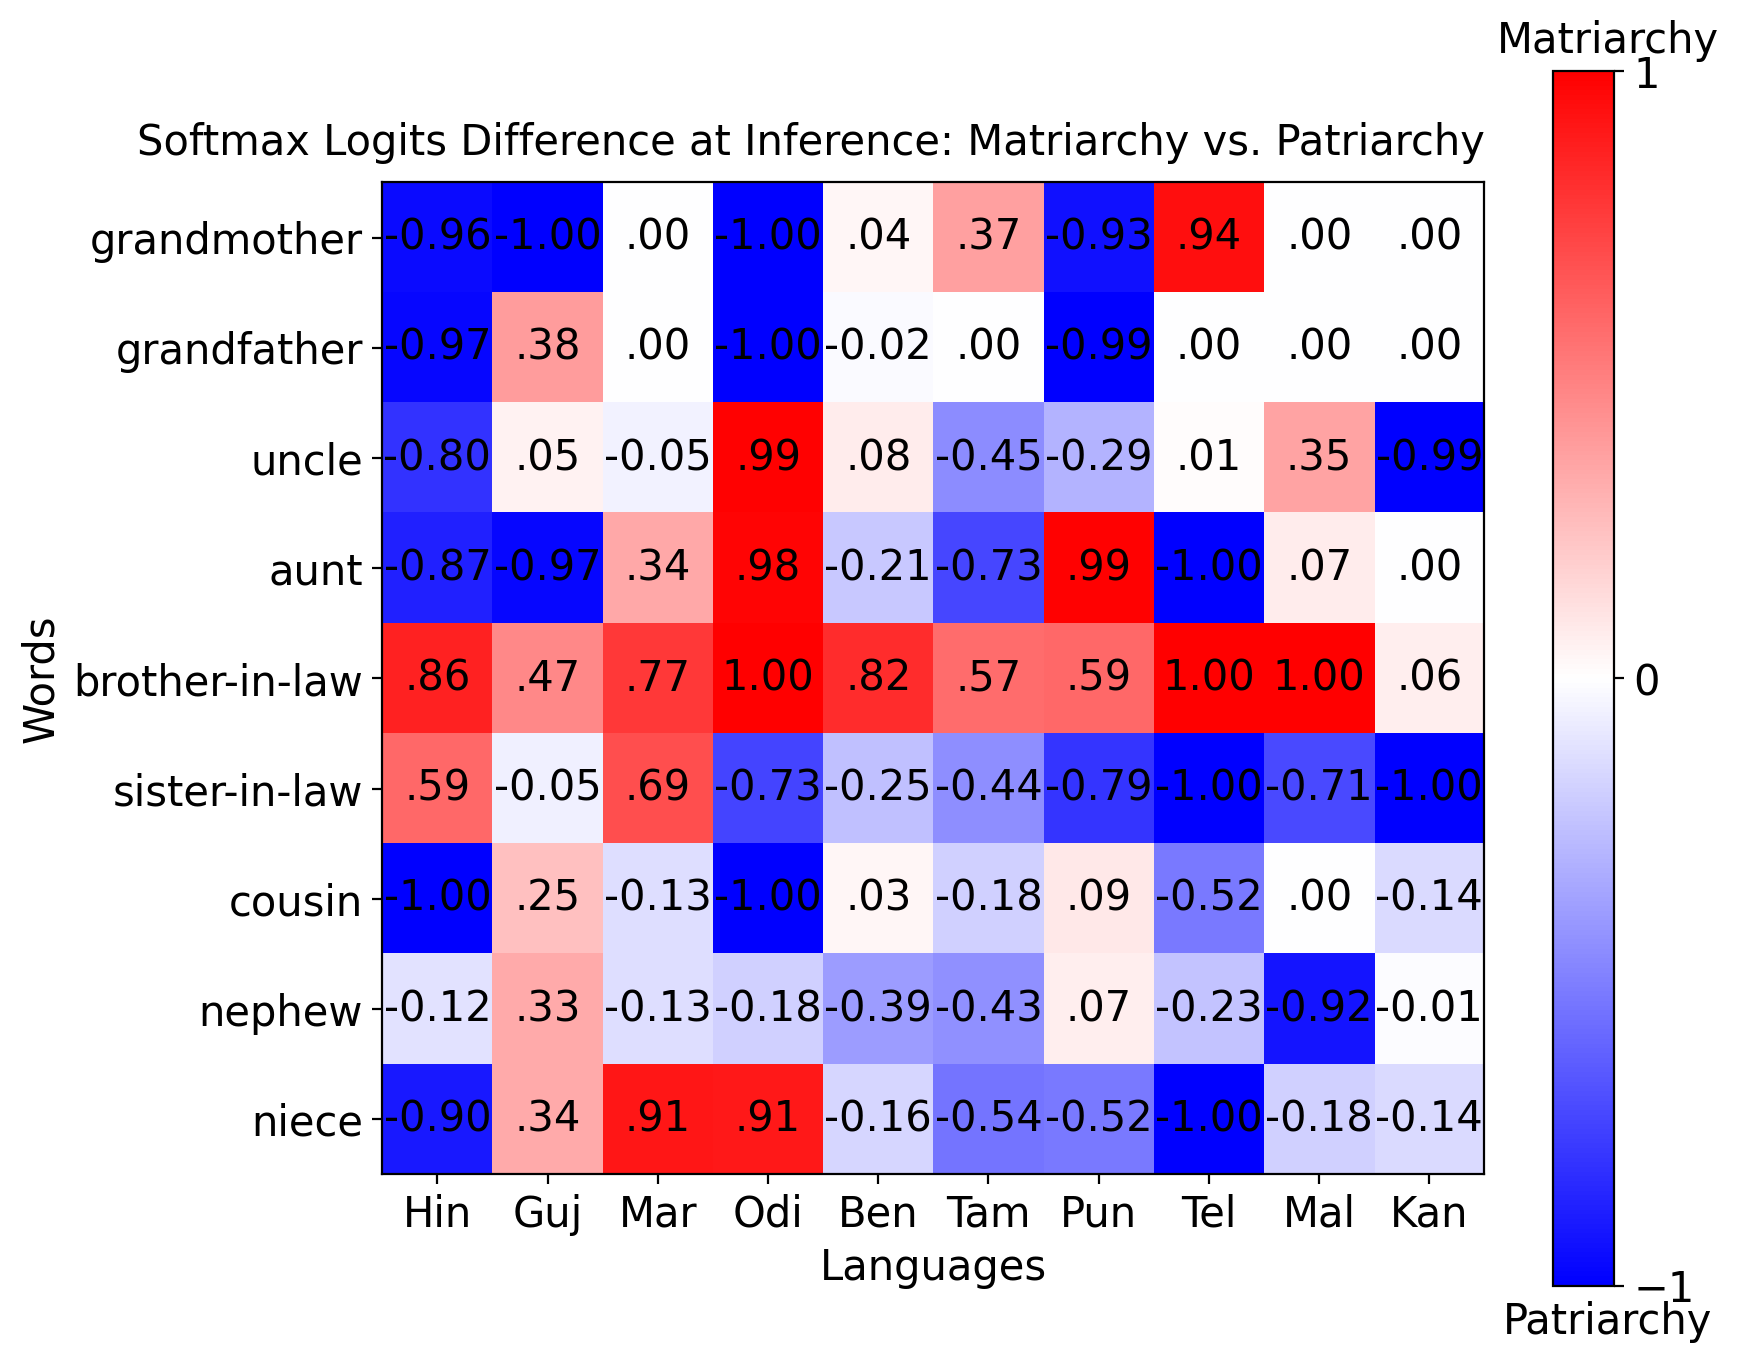

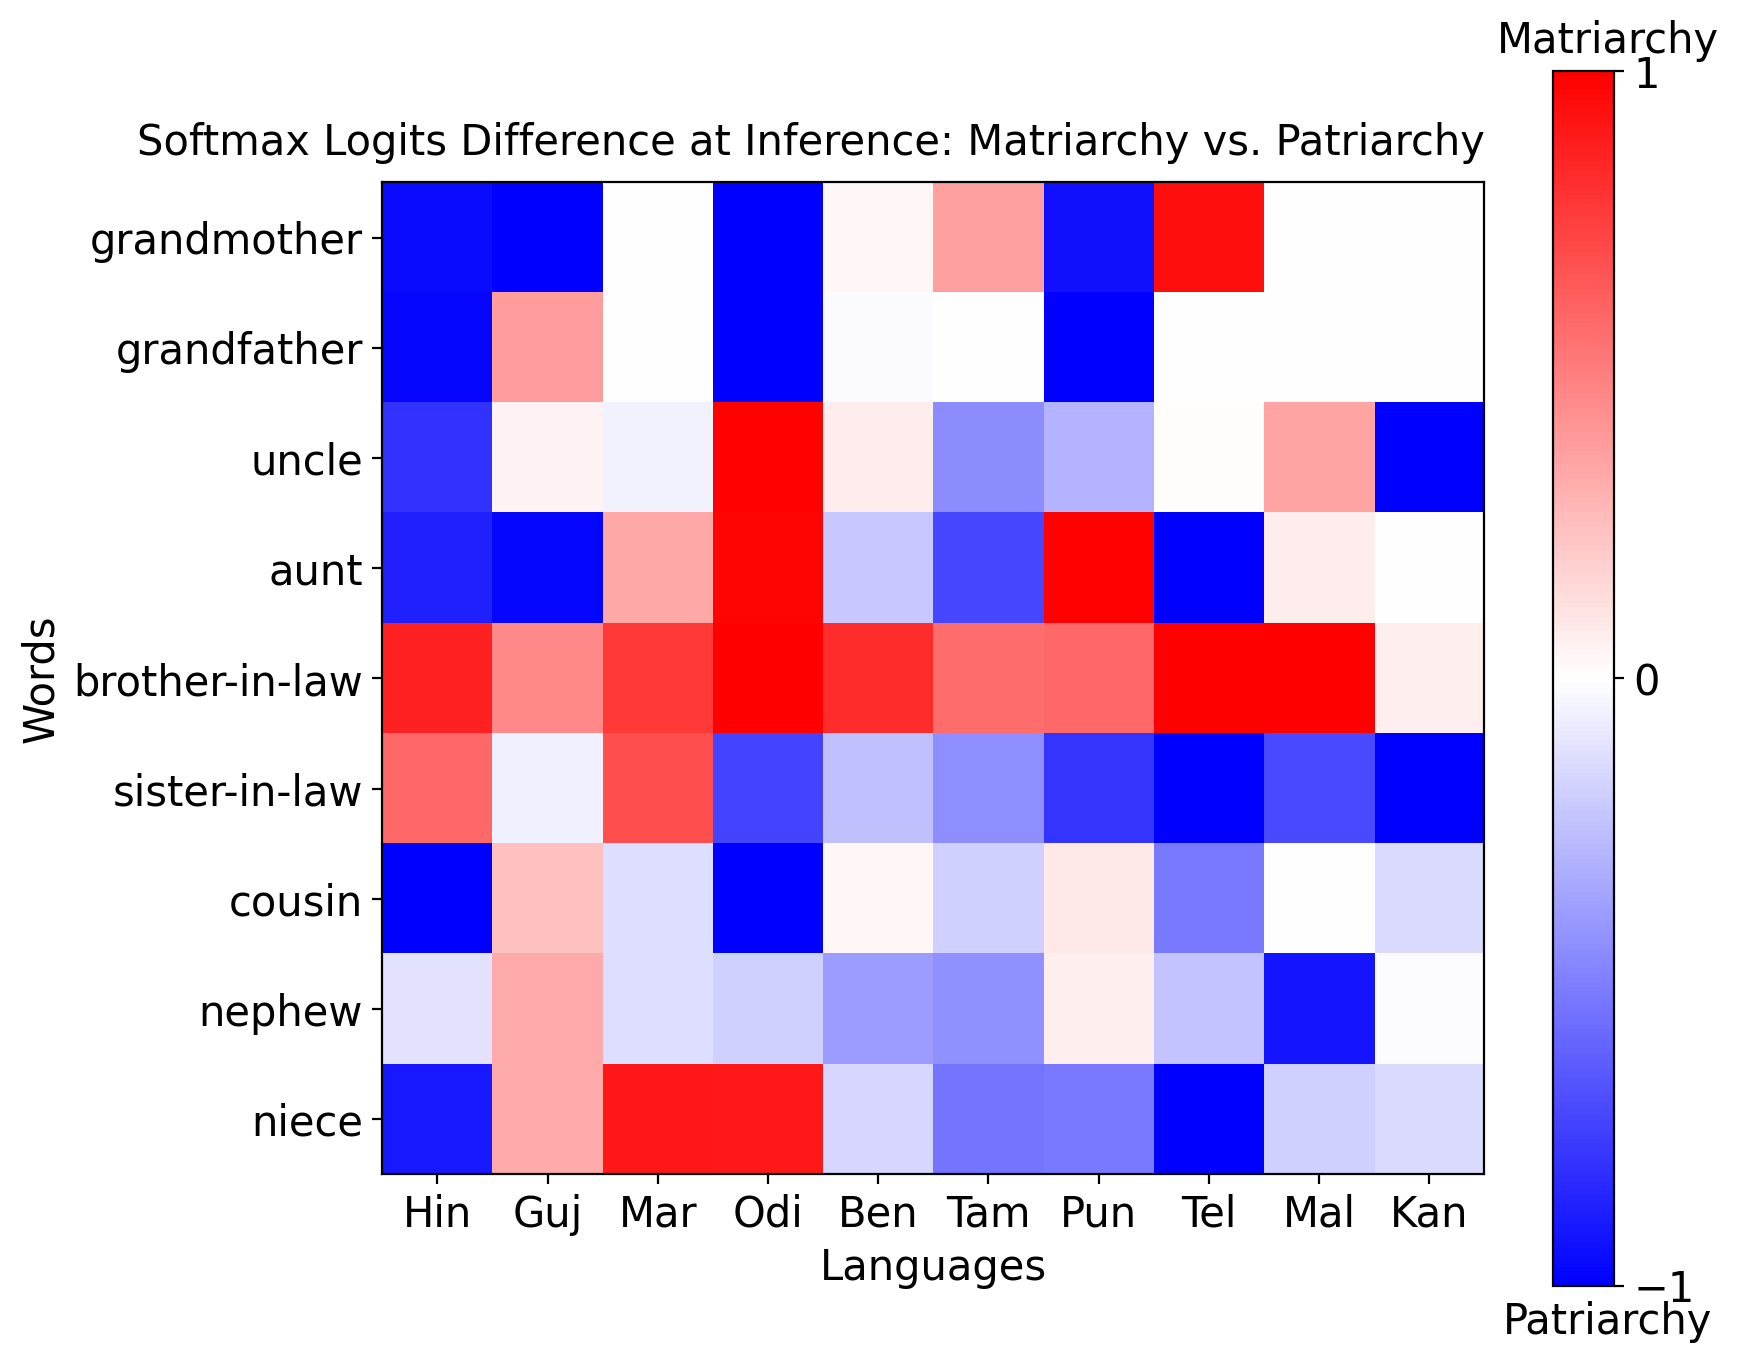

In [6]:

plot_confusion_mat(test_diff_confn_mat,  ambiguos_words, lang_code_map, annot=True, filename='logit_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Softmax Logits Difference at Inference: Matriarchy vs. Patriarchy')
plot_confusion_mat(test_diff_confn_mat,  ambiguos_words, lang_code_map, annot=False, filename='logit_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Softmax Logits Difference at Inference: Matriarchy vs. Patriarchy')
# plot_confusion_mat(confusion_mat_ratio,  ambiguos_words, lang_code_map, annot=True, filename='logit_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Inference')
# plot_confusion_mat(confusion_mat_ratio,  ambiguos_words, lang_code_map, annot=False, filename='logit_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Inference')

## Train Set details

In [7]:
trainset_counts={
    'tam_Taml': {'uncle': {'Matriarch': 1107, 'Patriarch': 11}, 'aunt': {'B': 207, 'Matriarch': 24}, 'grandfather': {'B': 1234}, 'grandmother': {'B': 294}, 'brother-in-law': {'Matriarch': 34}, 'nephew': {'Matriarch': 1, 'Patriarch': 4}, 'niece': {'Matriarch': 2, 'Patriarch': 8}, 'sister-in-law': {'Matriarch': 10, 'Patriarch': 13}, 'cousin': {'Matriarch': 8, 'Patriarch': 43}}
,
'mar_Deva': {'uncle': {'Matriarch': 160, 'Patriarch': 265}, 'aunt': {'Matriarch': 48, 'Patriarch': 74}, 'grandfather': {'B': 966}, 'grandmother': {'B': 392}, 'brother-in-law': {'Matriarch': 47, 'Patriarch': 10}, 'nephew': {'Matriarch': 72, 'Patriarch': 2}, 'niece': {'Matriarch': 70, 'Patriarch': 33}, 'sister-in-law': {'Matriarch': 23, 'Patriarch': 24}, 'cousin': {'Matriarch': 6, 'Patriarch': 135}}
,
'ory_Orya': {'uncle': {'Matriarch': 95, 'Patriarch': 23}, 'aunt': {'Matriarch': 9, 'Patriarch': 4}, 'grandfather': {'Matriarch': 28, 'Patriarch': 129}, 'grandmother': {'Matriarch': 6, 'Patriarch': 107}, 'brother-in-law': {'Matriarch': 7, 'Patriarch': 2}, 'nephew': {'Matriarch': 14, 'Patriarch': 32}, 'niece': {'Matriarch': 9, 'Patriarch': 8}, 'sister-in-law': {'Matriarch': 7, 'Patriarch': 17}, 'cousin': {'Patriarch': 59}}
,
'hin_Deva': {'uncle': {'Matriarch': 619, 'Patriarch': 1894}, 'aunt': {'Matriarch': 241, 'Patriarch': 380}, 'grandfather': {'Matriarch': 169, 'Patriarch': 1702}, 'grandmother': {'Matriarch': 152, 'Patriarch': 1633}, 'brother-in-law': {'Matriarch': 341, 'Patriarch': 129}, 'nephew': {'Matriarch': 53, 'Patriarch': 291}, 'niece': {'Matriarch': 218, 'Patriarch': 627}, 'sister-in-law': {'Matriarch': 87, 'Patriarch': 410}, 'cousin': {'Matriarch': 614, 'Patriarch': 1698}}
,
'kan_Knda': {'uncle': {'Matriarch': 4, 'Patriarch': 896}, 'aunt': {'B': 367}, 'grandfather': {'B': 1188}, 'grandmother': {'B': 1552}, 'brother-in-law': {'Matriarch': 67, 'Patriarch': 12}, 'nephew': {'Patriarch': 4}, 'sister-in-law': {'Patriarch': 60}, 'cousin': {'Matriarch': 23, 'Patriarch': 29}}
,
'pan_Guru': {'uncle': {'Matriarch': 22, 'Patriarch': 124}, 'aunt': {'Matriarch': 55, 'Patriarch': 19}, 'grandfather': {'Matriarch': 25, 'Patriarch': 374}, 'grandmother': {'Matriarch': 103, 'Patriarch': 294}, 'brother-in-law': {'Matriarch': 44}, 'nephew': {'Patriarch': 54}, 'niece': {'Patriarch': 75}, 'sister-in-law': {'Matriarch': 4, 'Patriarch': 11}, 'cousin': {'Matriarch': 111, 'Patriarch': 15}}
,
'tel_Telu': {'uncle': {'Matriarch': 281}, 'aunt': {'B': 9, 'Patriarch': 303}, 'grandfather': {'B': 42}, 'grandmother': {'Matriarch': 553, 'Patriarch': 2}, 'brother-in-law': {'B': 1, 'Matriarch': 39}, 'nephew': {'Matriarch': 6}, 'niece': {'Matriarch': 3, 'Patriarch': 113}, 'sister-in-law': {'Patriarch': 11}, 'cousin': {'Patriarch': 23}}
,
'mal_Mlym': {'uncle': {'B': 519, 'Matriarch': 13}, 'aunt': {'Matriarch': 9}, 'grandfather': {'B': 64}, 'grandmother': {'B': 290}, 'brother-in-law': {'B': 1, 'Matriarch': 2}, 'nephew': {'Matriarch': 27, 'Patriarch': 46}, 'niece': {'Matriarch': 12, 'Patriarch': 11}, 'sister-in-law': {'B': 2, 'Matriarch': 5}, 'cousin': {'B': 273}}
,
'guj_Gujr': {'uncle': {'Matriarch': 95, 'Patriarch': 807}, 'aunt': {'Matriarch': 43, 'Patriarch': 232}, 'grandfather': {'Matriarch': 28, 'Patriarch': 1133}, 'grandmother': {'Matriarch': 32, 'Patriarch': 1037}, 'brother-in-law': {'Matriarch': 54, 'Patriarch': 11}, 'nephew': {'Matriarch': 24, 'Patriarch': 56}, 'niece': {'Matriarch': 18, 'Patriarch': 207}, 'sister-in-law': {'Matriarch': 11, 'Patriarch': 114}, 'cousin': {'Matriarch': 28, 'Patriarch': 5}}
,
'ben_Beng': {'uncle': {'Matriarch': 163, 'Patriarch': 5}, 'grandfather': {'Matriarch': 423, 'Patriarch': 24}, 'grandmother': {'Patriarch': 14}, 'brother-in-law': {'Patriarch': 3}, 'cousin': {'Matriarch': 3, 'Patriarch': 383}}

}

In [8]:

# check if trainset_counts has the same keys as lang_script_list
# check if the values of trainset_counts are dictionaries with keys as the ambiguos words
# if not then add the key with value as empty dictionary and then add the values of the ambiguos words as 0

for lang in lang_script_list:
    if trainset_counts.get(lang, None) is None:
        print("Adding lang", lang)
        trainset_counts[lang] = {}
    for word in ambiguos_words:

        if trainset_counts[lang].get(word, None) is None:
            print("Adding word", word, "for lang", lang)
            trainset_counts[lang][word] = {}
            trainset_counts[lang][word]['Matriarch'] = 0
            trainset_counts[lang][word]['Patriarch'] = 0
print(trainset_counts)
# for each language in lang_script_list
# for each word in ambiguos_words
# make 2 confusion matrices - train_diff_res and train_ratio_res based on softmax of patriarchy and matriarchy counts from trainset_counts

train_diff_res={}
train_ratio_res={}

for lang in lang_script_list:
    if train_diff_res.get(lang, None) is None:
        train_diff_res[lang] = {}
    if train_ratio_res.get(lang, None) is None:
        train_ratio_res[lang] = {}
    for word in ambiguos_words:
        matriarchal_count = trainset_counts[lang][word].get('Matriarch', 0)
        patriarchal_count = trainset_counts[lang][word].get('Patriarch', 0)
        neutral_count = trainset_counts[lang][word].get('B', 0)
        if matriarchal_count == 0 and patriarchal_count == 0 and neutral_count == 0: # no bias in language
            train_diff_res[lang][word] = 0
            train_ratio_res[lang][word] = 0
        elif matriarchal_count >= 0 and patriarchal_count >= 0:
            effective_counts = torch.tensor([matriarchal_count, patriarchal_count], dtype=torch.float32)
            effective_counts = softmax(effective_counts, dim=0)
            matriarchal_counts_softmax = effective_counts[0]
            patriarchal_counts_softmax = effective_counts[1]

            diff = matriarchal_counts_softmax - patriarchal_counts_softmax
            ratio = matriarchal_counts_softmax / patriarchal_counts_softmax

            train_diff_res[lang][word] = diff.item()
            train_ratio_res[lang][word] = ratio.item()
        else:
            train_diff_res[lang][word] = np.nan
            train_ratio_res[lang][word] = np.nan
            # print(f"Skipping word: {word} in lang: {lang} due to empty logits and  LANGUAGE IS BIASED.", "patriarchal" if len(matriarchal_logits) == 0 else "matriarchal")



print(train_diff_res)
# train_diff_res = np.array(train_diff_res, dtype=object) # Convert to NumPy array with object dtype first
# for i, lang in enumerate((lang_script_list)):
#     for j, word in enumerate((ambiguos_words)):
#         try:
#             train_diff_res[lang][word] = float(train_diff_res[lang][word])  # Try converting to float
#         except (ValueError, TypeError):  # Handle non-numerical values
#             train_diff_res[lang][word] = np.nan # Replace with actual NaN

# # train_diff_res = train_diff_res.astype(float) # Now convert the whole array to float
# train_diff_res
print("Train Diff res")
print(train_diff_res)

print("Train Ratio res")
print(train_ratio_res)


# make a 2D array of the train_diff_res.. not dataframe but 2D array
train_diff_confusion_mat =[[train_diff_res[lang][word] for lang in (lang_script_list)] for word in (ambiguos_words) ]
# confusion_mat
# print the confusion matrix in tabular form
print("Train Confusion matrix")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(train_diff_confusion_mat[i][j], end="\t")
    print()

train_ratio_conf_mat =[[train_ratio_res[lang][word] for lang in (lang_script_list)] for word in (ambiguos_words) ]
# confusion_mat
# print the confusion matrix in tabular form
print("Train Ratio Confusion matrix")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(train_ratio_conf_mat[i][j], end="\t")
    print()


Adding word aunt for lang ben_Beng
Adding word sister-in-law for lang ben_Beng
Adding word nephew for lang ben_Beng
Adding word niece for lang ben_Beng
Adding word niece for lang kan_Knda
{'tam_Taml': {'uncle': {'Matriarch': 1107, 'Patriarch': 11}, 'aunt': {'B': 207, 'Matriarch': 24}, 'grandfather': {'B': 1234}, 'grandmother': {'B': 294}, 'brother-in-law': {'Matriarch': 34}, 'nephew': {'Matriarch': 1, 'Patriarch': 4}, 'niece': {'Matriarch': 2, 'Patriarch': 8}, 'sister-in-law': {'Matriarch': 10, 'Patriarch': 13}, 'cousin': {'Matriarch': 8, 'Patriarch': 43}}, 'mar_Deva': {'uncle': {'Matriarch': 160, 'Patriarch': 265}, 'aunt': {'Matriarch': 48, 'Patriarch': 74}, 'grandfather': {'B': 966}, 'grandmother': {'B': 392}, 'brother-in-law': {'Matriarch': 47, 'Patriarch': 10}, 'nephew': {'Matriarch': 72, 'Patriarch': 2}, 'niece': {'Matriarch': 70, 'Patriarch': 33}, 'sister-in-law': {'Matriarch': 23, 'Patriarch': 24}, 'cousin': {'Matriarch': 6, 'Patriarch': 135}}, 'ory_Orya': {'uncle': {'Matriarch'

/tmp/ipykernel_1983704/159688876.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ambiguos_words, fontsize=15)


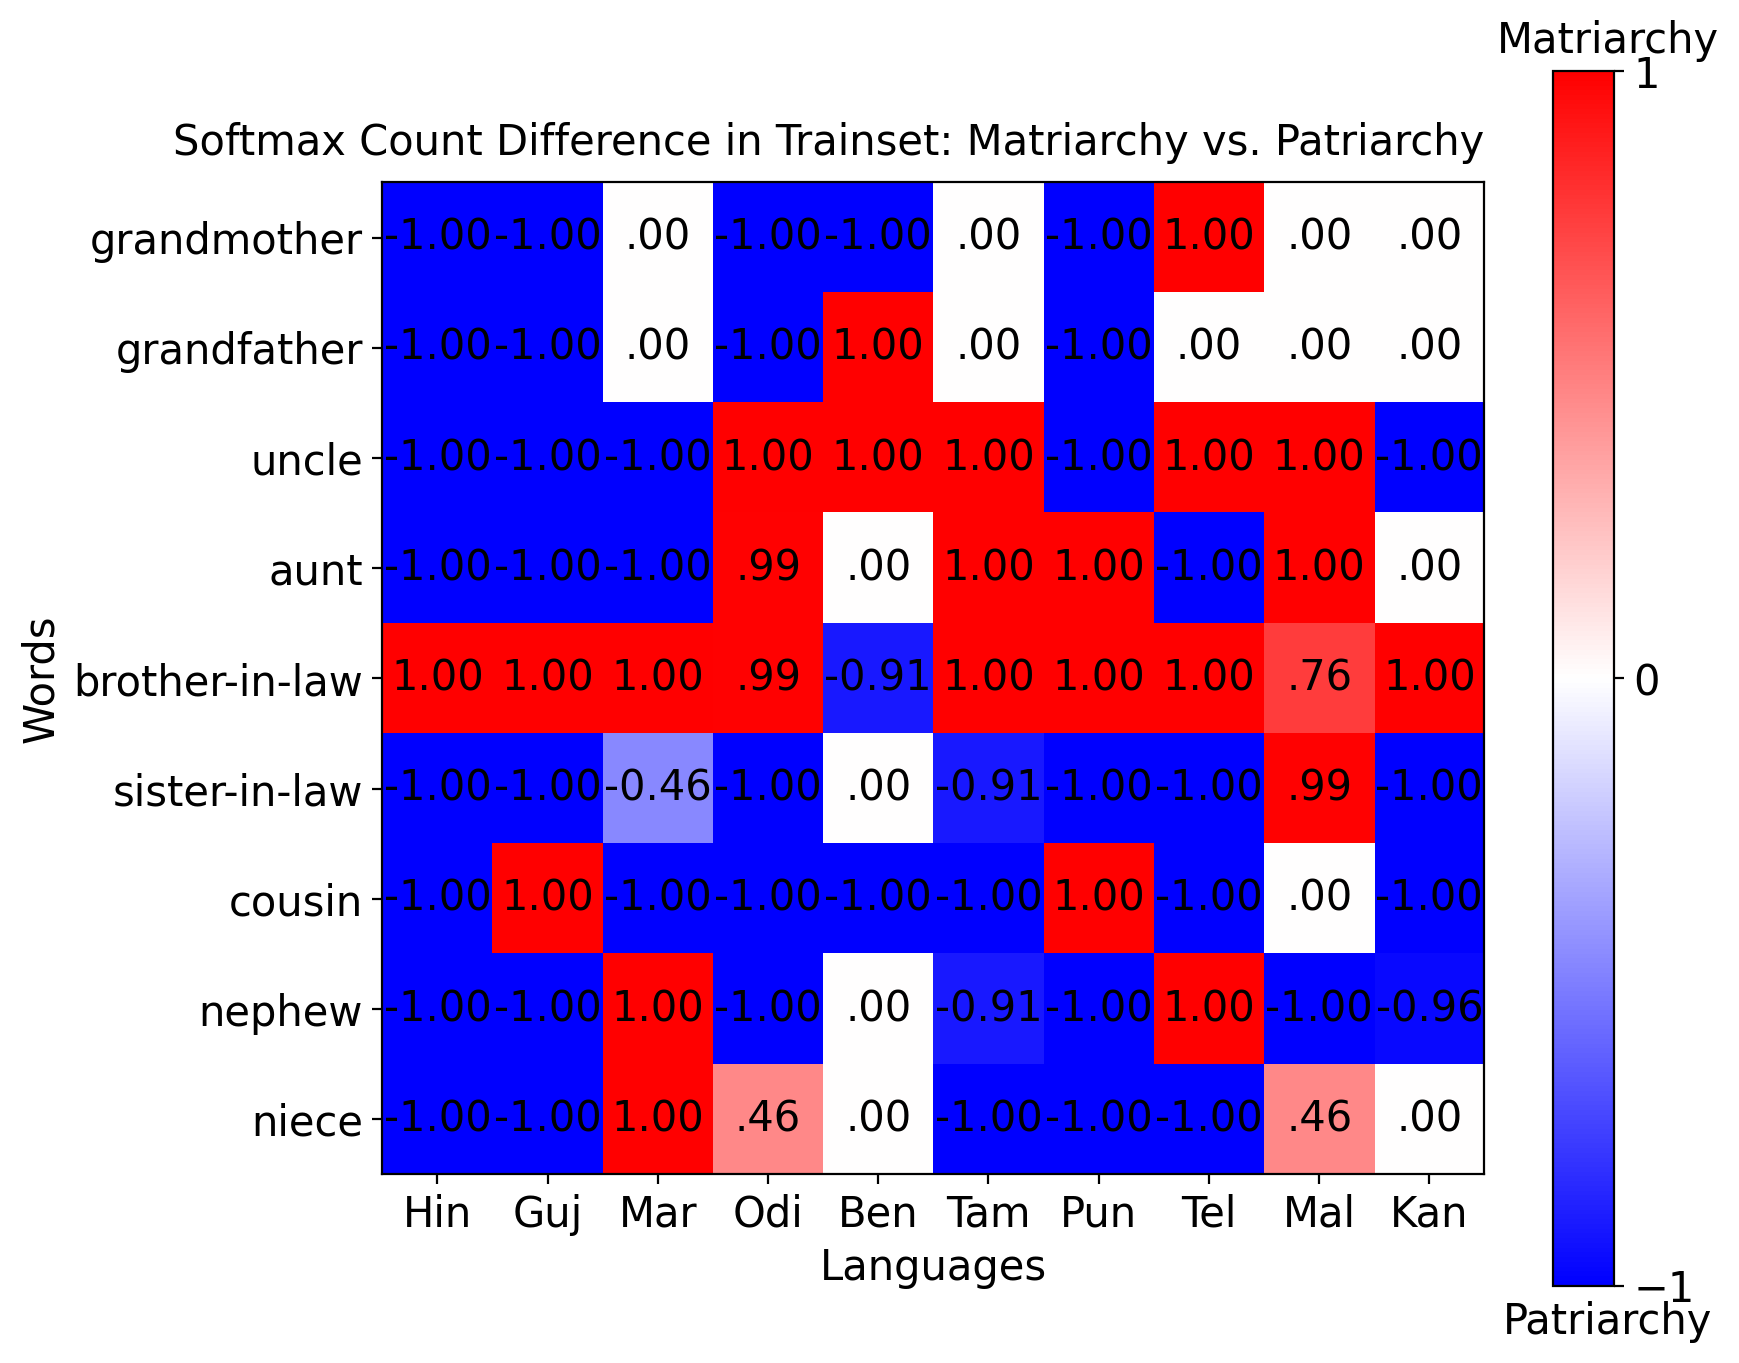

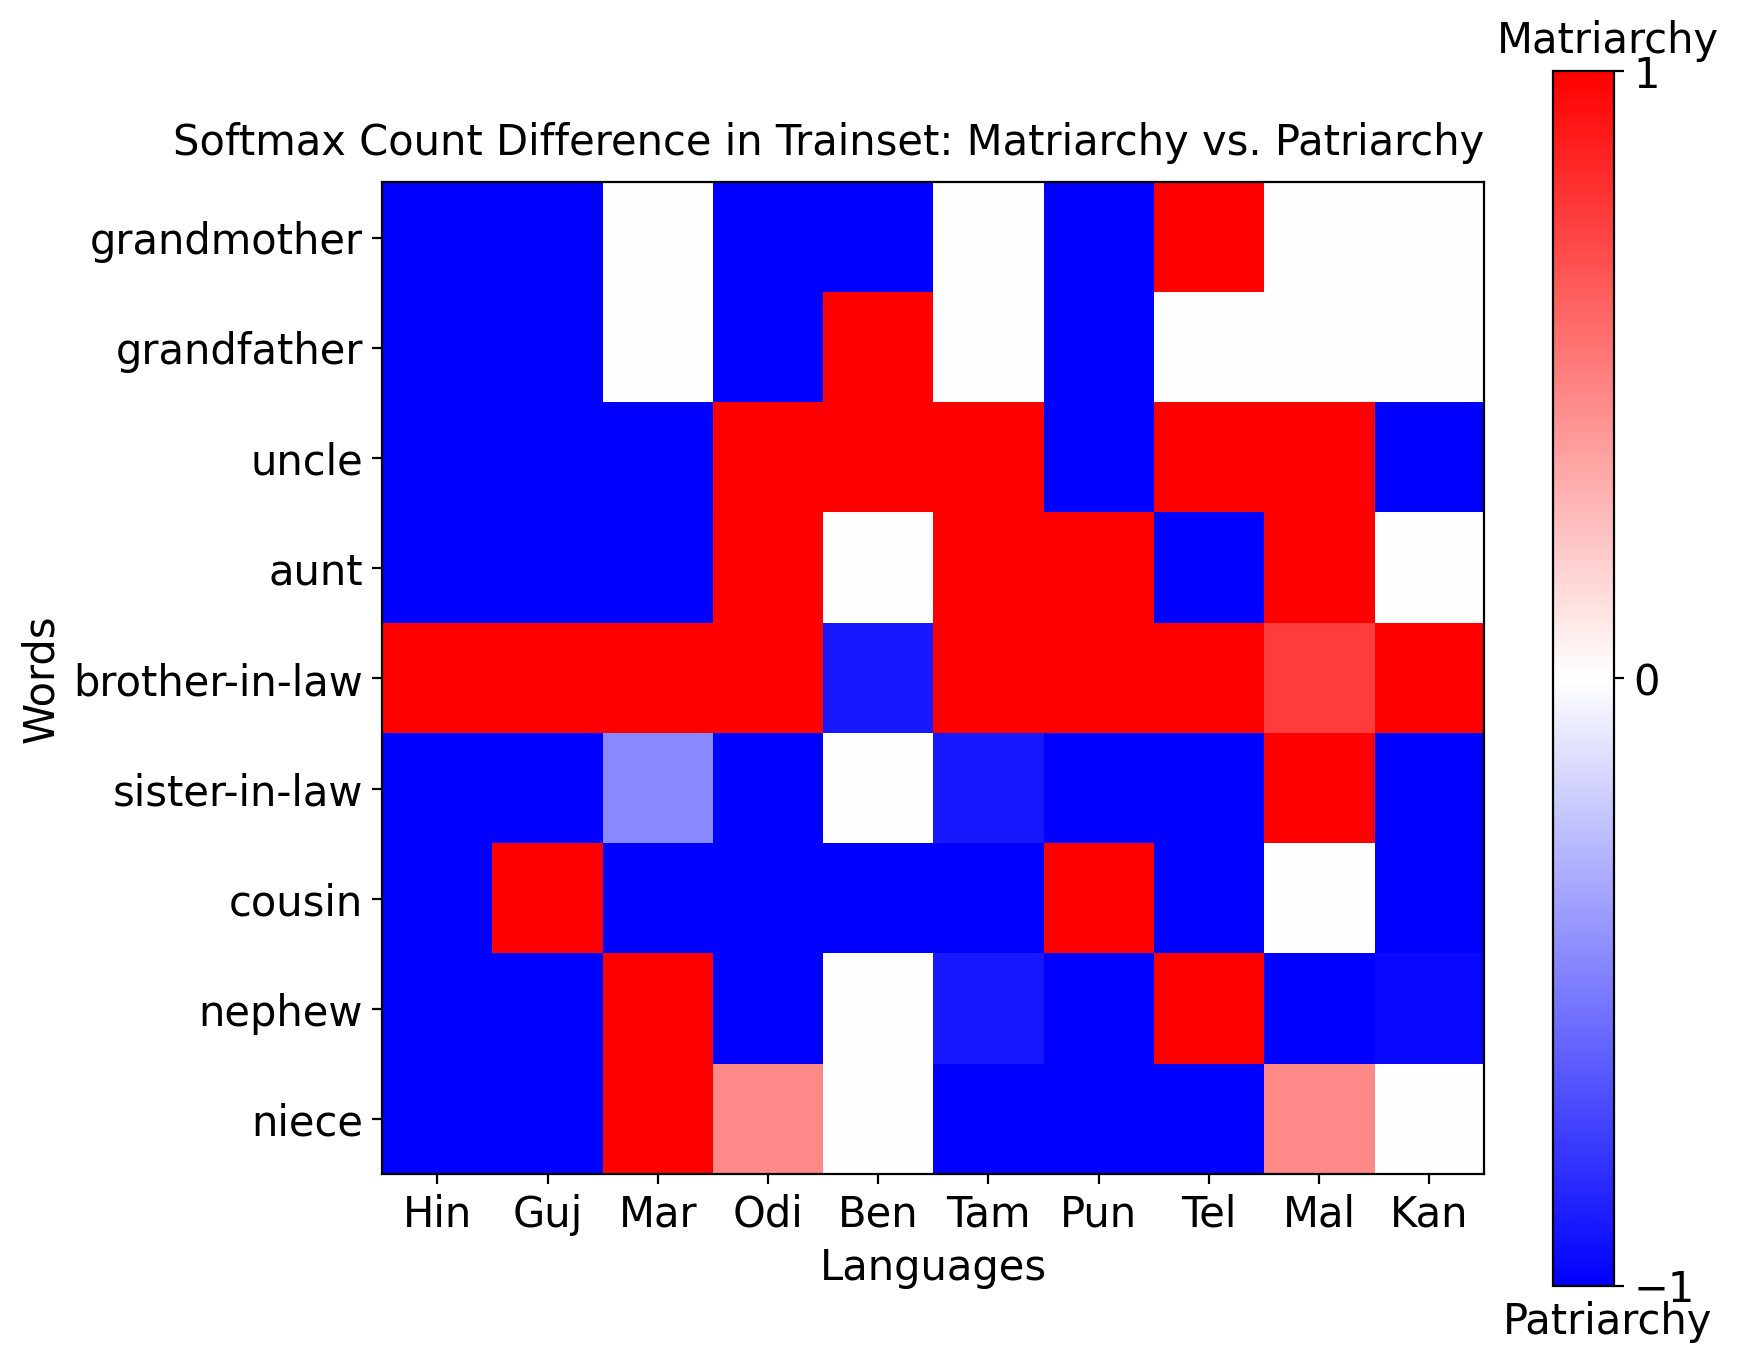

In [9]:

plot_confusion_mat(train_diff_confusion_mat,  ambiguos_words, lang_code_map, annot=True, filename='trainset_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Softmax Count Difference in Trainset: Matriarchy vs. Patriarchy')
plot_confusion_mat(train_diff_confusion_mat,  ambiguos_words, lang_code_map, annot=False, filename='trainset_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.bwr, legend_title='Softmax Count Difference in Trainset: Matriarchy vs. Patriarchy')
# plot_confusion_mat(train_ratio_conf_mat,  ambiguos_words, lang_code_map, annot=True, filename='trainset_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Trainset')
# plot_confusion_mat(train_ratio_conf_mat,  ambiguos_words, lang_code_map, annot=False, filename='trainset_prob_ratio_'+str(SAMPLE_SIZE), cmap_name=plt.cm.Oranges, legend_title='Ratio of Logits for Matriarchal and Patriarchal Relations in Trainset')

### Orientation : 
majorly cell is/was matriarchy or patriarchy

In [10]:
test_train_orientation = [[0 for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))]

for i, word in enumerate(ambiguos_words):
    for j in range(len(lang_script_list)):
        if train_diff_confusion_mat[i][j] > 0 and test_diff_confn_mat[i][j] > 0: # both are matriarchal
            test_train_orientation[i][j] = 'A'
        elif train_diff_confusion_mat[i][j] < 0 and test_diff_confn_mat[i][j] < 0: # both are patriarchal
            test_train_orientation[i][j] = 'B'
        elif train_diff_confusion_mat[i][j] > 0 and test_diff_confn_mat[i][j] < 0:# train is matriarchal and test is patriarchal
            test_train_orientation[i][j] = 'C'
        elif train_diff_confusion_mat[i][j] < 0 and test_diff_confn_mat[i][j] > 0: # train is patriarchal and test is matriarchal
            test_train_orientation[i][j] = 'D'
        elif train_diff_confusion_mat[i][j] == 0 and test_diff_confn_mat[i][j] >0: # train is neutral and test is matriarchal
            test_train_orientation[i][j] = 'E'
        elif train_diff_confusion_mat[i][j] == 0 and test_diff_confn_mat[i][j] <0: # train is neutral and test is patriarchal

            test_train_orientation[i][j] = 'F'
        elif train_diff_confusion_mat[i][j] > 0 and test_diff_confn_mat[i][j] == 0: # train is matriarchal and test is neutral --- no cases
            test_train_orientation[i][j] = 'G'
        elif train_diff_confusion_mat[i][j] < 0 and test_diff_confn_mat[i][j] == 0: # train is patriarchal and test is neutral --- no cases
            test_train_orientation[i][j] = 'H'
        else: # both are neutral??
            print(train_diff_confusion_mat[i][j], test_diff_confn_mat[i][j])
            test_train_orientation[i][j] = 'I'

print(test_train_orientation)

0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
[['B', 'B', 'I', 'B', 'D', 'E', 'B', 'A', 'I', 'I'], ['B', 'D', 'I', 'B', 'C', 'I', 'B', 'I', 'I', 'I'], ['B', 'D', 'B', 'A', 'A', 'C', 'B', 'A', 'A', 'B'], ['B', 'B', 'D', 'A', 'F', 'C', 'A', 'B', 'A', 'I'], ['A', 'A', 'A', 'A', 'D', 'A', 'A', 'A', 'A', 'A'], ['D', 'B', 'D', 'B', 'F', 'B', 'B', 'B', 'C', 'B'], ['B', 'A', 'B', 'B', 'D', 'B', 'A', 'B', 'I', 'B'], ['B', 'D', 'C', 'B', 'F', 'B', 'D', 'C', 'B', 'B'], ['B', 'D', 'A', 'A', 'F', 'B', 'B', 'B', 'C', 'F']]


In [11]:
# value count for each category
value_counts = {}

for i in range(len(ambiguos_words)):
    for j in range(len(lang_script_list)):
        value = test_train_orientation[i][j]
        if value_counts.get(value, None) is None:
            value_counts[value] = 0
        value_counts[value] += 1

print(value_counts, len(ambiguos_words)*len(lang_script_list))

{'B': 35, 'I': 10, 'D': 11, 'E': 1, 'A': 21, 'C': 7, 'F': 5} 90


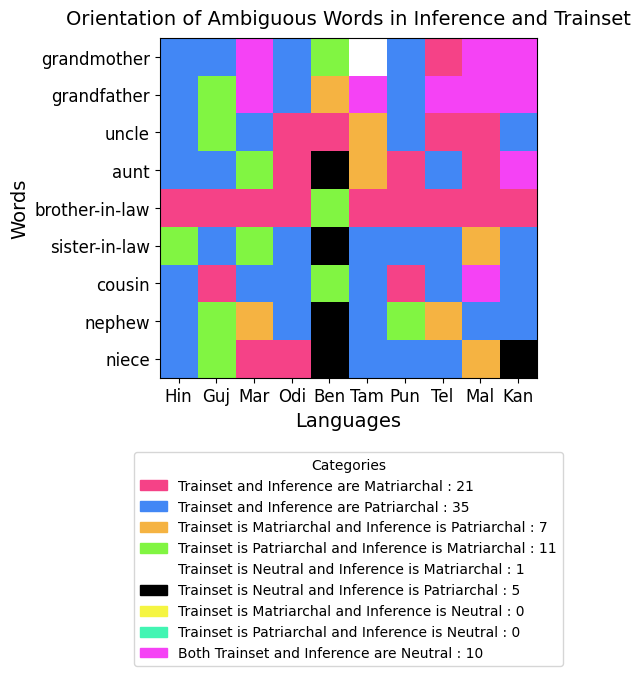

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def plot_orientation_mat(data, ambiguos_words, lang_code_map, lang_script_list, filename, legend_title):
    # Define category colors
    category_colors = {
        'A': '#f54287',  # Pink
        'B': '#4287f5',  # Blue
        'C': '#f5b342',  # Orange
        'D': '#81f542',  # Green
        'E': '#FFFFFF',  # White
        'F': '#000000',  # Black
        'G': '#f5f542',  # Yellow
        'H': '#42f5b3',  # Cyan
        'I': '#f542f5'   # Magenta


    }
    category_labels ={
        'A': 'Trainset and Inference are Matriarchal',
        'B': 'Trainset and Inference are Patriarchal',
        'C': 'Trainset is Matriarchal and Inference is Patriarchal',
        'D': 'Trainset is Patriarchal and Inference is Matriarchal',
        'E': 'Trainset is Neutral and Inference is Matriarchal',
        'F': 'Trainset is Neutral and Inference is Patriarchal',
        'G': 'Trainset is Matriarchal and Inference is Neutral',
        'H': 'Trainset is Patriarchal and Inference is Neutral',
        'I': 'Both Trainset and Inference are Neutral'
    }
    
    # Convert data to numeric representation for plotting
    categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
    data_numeric = np.array([[categories.index(cell) for cell in row] for row in data])

    # Create a custom colormap
    cmap = ListedColormap([category_colors[c] for c in categories])

    # Create figure
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Plot confusion matrix with categorical colors
    cax = ax.matshow(data_numeric, cmap=cmap, )

    # Set x-axis (Languages)
    ax.set_xticks(range(len(lang_script_list)))
    ax.set_xticklabels([lang_code_map[lang] for lang in lang_script_list], ha="center", fontsize=12)
    ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to bottom

    # Set y-axis (Words)
    ax.set_yticks(range(len(ambiguos_words)))
    ax.set_yticklabels(ambiguos_words, fontsize=12)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.8)  # Grid lines


    # Set labels
    plt.xlabel('Languages', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title(legend_title, fontsize=14, pad=10)

    # Force cells to be square
    ax.set_aspect("equal")

    # Create a color legend manually
    from matplotlib.patches import Patch
    legend_patches = [Patch(color=category_colors[c], label= category_labels[c]+' : '+str(value_counts.get(c, 0))) for c in categories]
    # ax.legend(handles=legend_patches, title="Categories", loc='lower center', bbox_to_anchor=(0.5, -1.17))
    # Add legend below the plot
    ax.legend(
        handles=legend_patches, 
        title="Categories", 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.2),  # Move it further down
        ncol=1,  # Single column
        frameon=True
    )

    # Adjust layout to prevent shrinking
    plt.subplots_adjust(bottom=0.3)  # Pushes the plot higher so the legend fits



    # Save the plot
    plt.tight_layout()
    fig.savefig(f'../results/logits_{filename}.png')
    plt.show()

# Example usage
plot_orientation_mat(test_train_orientation, ambiguos_words, lang_code_map, lang_script_list, 
                     filename='test_train_orientation', 
                     legend_title='Orientation of Ambiguous Words in Inference and Trainset')


### Intensity:

In [13]:
test_train_intensity = [[{'category':'X', 'intensity':55} for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))]

for i, word in enumerate(ambiguos_words):
    for j in range(len(lang_script_list)):
        if train_diff_confusion_mat[i][j] > 0 and test_diff_confn_mat[i][j] > 0: # both are matriarchal
            test_train_intensity[i][j]['category'] = 'A'
            test_train_intensity[i][j]['intensity'] = abs(train_diff_confusion_mat[i][j] - test_diff_confn_mat[i][j])
        elif train_diff_confusion_mat[i][j] < 0 and test_diff_confn_mat[i][j] < 0: # both are patriarchal
            test_train_intensity[i][j]['category'] = 'B'
            test_train_intensity[i][j]['intensity'] = abs(train_diff_confusion_mat[i][j] - test_diff_confn_mat[i][j])
        elif train_diff_confusion_mat[i][j] > 0 and test_diff_confn_mat[i][j] < 0:# train is matriarchal and test is patriarchal
            test_train_intensity[i][j]['category'] = 'C'
            test_train_intensity[i][j]['intensity'] = abs(train_diff_confusion_mat[i][j] - test_diff_confn_mat[i][j])
        elif train_diff_confusion_mat[i][j] < 0 and test_diff_confn_mat[i][j] > 0: # train is patriarchal and test is matriarchal
            test_train_intensity[i][j]['category'] = 'D'
            test_train_intensity[i][j]['intensity'] = abs(train_diff_confusion_mat[i][j] - test_diff_confn_mat[i][j])
        elif train_diff_confusion_mat[i][j] == 0 and test_diff_confn_mat[i][j] >0: # train is neutral and test is matriarchal
            test_train_intensity[i][j]['category'] = 'E'
            test_train_intensity[i][j]['intensity'] = abs(train_diff_confusion_mat[i][j] - test_diff_confn_mat[i][j])
        elif train_diff_confusion_mat[i][j] == 0 and test_diff_confn_mat[i][j] <0: # train is neutral and test is patriarchal

            test_train_intensity[i][j]['category'] = 'F'
            test_train_intensity[i][j]['intensity'] = abs(train_diff_confusion_mat[i][j] - test_diff_confn_mat[i][j])
        elif train_diff_confusion_mat[i][j] > 0 and test_diff_confn_mat[i][j] == 0: # train is matriarchal and test is neutral --- no cases
            test_train_intensity[i][j]['category'] = 'G'
            test_train_intensity[i][j]['intensity'] = abs(train_diff_confusion_mat[i][j] - test_diff_confn_mat[i][j])
        elif train_diff_confusion_mat[i][j] < 0 and test_diff_confn_mat[i][j] == 0: # train is patriarchal and test is neutral --- no cases
            test_train_intensity[i][j]['category'] = 'H'
            test_train_intensity[i][j]['intensity'] = abs(train_diff_confusion_mat[i][j] - test_diff_confn_mat[i][j])
        else: # both are neutral??
            print(train_diff_confusion_mat[i][j], test_diff_confn_mat[i][j])
            test_train_intensity[i][j]['category'] = 'I'
            test_train_intensity[i][j]['intensity'] = abs(train_diff_confusion_mat[i][j] - test_diff_confn_mat[i][j])

print(test_train_intensity)

0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
[[{'category': 'B', 'intensity': 0.04363280534744263}, {'category': 'B', 'intensity': 0.004044830799102783}, {'category': 'I', 'intensity': 0.0}, {'category': 'B', 'intensity': 0.00029724836349487305}, {'category': 'D', 'intensity': 1.038295418024063}, {'category': 'E', 'intensity': 0.3729094862937927}, {'category': 'B', 'intensity': 0.06585609912872314}, {'category': 'A', 'intensity': 0.056821346282958984}, {'category': 'I', 'intensity': 0.0}, {'category': 'I', 'intensity': 0.0}], [{'category': 'B', 'intensity': 0.027211248874664307}, {'category': 'D', 'intensity': 1.3833677470684052}, {'category': 'I', 'intensity': 0.0}, {'category': 'B', 'intensity': 0.0009686946868896484}, {'category': 'C', 'intensity': 1.0205633044242859}, {'category': 'I', 'intensity': 0.0}, {'category': 'B', 'intensity': 0.0070304274559021}, {'category': 'I', 'intensity': 0.0}, {'category': 'I', 'intensity': 0.0}, {'category': 'I', 'intensity': 0.0}], [

In [14]:
# value_counts_intensity = {}
# for i in range(len(ambiguos_words)):
#     for j in range(len(lang_script_list)):
#         value = test_train_intensity[i][j]['category']
#         if value_counts_intensity.get(value, None) is None:
#             value_counts_intensity[value] = 0
#         value_counts_intensity[value] += 1

# print(value_counts_intensity, len(ambiguos_words)*len(lang_script_list))

In [15]:

# def plot_intensity_mat(data, ambiguos_words, lang_code_map, lang_script_list, filename, legend_title):
#     # Define category colors
#     category_colors = {
#         'A': '#f54287',  # Pink
#         'B': '#4287f5',  # Blue
#         'C': '#f5b342',  # Orange
#         'D': '#81f542',  # Green
#         'E': '#FFFFFF',  # White
#         'F': '#000000',  # Black
#         'G': '#f5f542',  # Yellow
#         'H': '#42f5b3',  # Cyan
#         'I': '#f542f5'   # Magenta


#     }
#     category_labels ={
#         'A': 'Trainset and Inference are Matriarchal',
#         'B': 'Trainset and Inference are Patriarchal',
#         'C': 'Trainset is Matriarchal and Inference is Patriarchal',
#         'D': 'Trainset is Patriarchal and Inference is Matriarchal',
#         'E': 'Trainset is Neutral and Inference is Matriarchal',
#         'F': 'Trainset is Neutral and Inference is Patriarchal',
#         'G': 'Trainset is Matriarchal and Inference is Neutral',
#         'H': 'Trainset is Patriarchal and Inference is Neutral',
#         'I': 'Both Trainset and Inference are Neutral'
#     }
    
#     # Convert data to numeric representation for plotting
#     categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
#     # data_numeric will be the intensity instead of the category
#     data_numeric = np.array([[data[i][j]['intensity'] for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))])
#     print("data numeric::", data_numeric)

#     # Create a custom colormap
#     cmap = ListedColormap([category_colors[c] for c in categories])

#     # Create figure
#     fig, ax = plt.subplots(figsize=(7, 7))
    
#     # Plot confusion matrix with categorical colors
#     cax = ax.matshow(data_numeric, cmap=cmap, )

#     # Set x-axis (Languages)
#     ax.set_xticks(range(len(lang_script_list)))
#     ax.set_xticklabels([lang_code_map[lang] for lang in lang_script_list], ha="center", fontsize=12)
#     ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to bottom

#     # Set y-axis (Words)
#     ax.set_yticks(range(len(ambiguos_words)))
#     ax.set_yticklabels(ambiguos_words, fontsize=12)
#     ax.grid(which="minor", color="black", linestyle='-', linewidth=0.8)  # Grid lines


#     # Set labels
#     plt.xlabel('Languages', fontsize=14)
#     plt.ylabel('Words', fontsize=14)
#     plt.title(legend_title, fontsize=14, pad=10)

#     # Force cells to be square
#     ax.set_aspect("equal")

#     # Create a color legend manually
#     from matplotlib.patches import Patch
#     legend_patches = [Patch(color=category_colors[c], label= category_labels[c]+' : '+str(value_counts.get(c, 0))) for c in categories]
#     # ax.legend(handles=legend_patches, title="Categories", loc='lower center', bbox_to_anchor=(0.5, -1.17))
#     # Add legend below the plot
#     ax.legend(
#         handles=legend_patches, 
#         title="Categories", 
#         loc='upper center', 
#         bbox_to_anchor=(0.5, -0.2),  # Move it further down
#         ncol=1,  # Single column
#         frameon=True
#     )

#     # Adjust layout to prevent shrinking
#     plt.subplots_adjust(bottom=0.3)  # Pushes the plot higher so the legend fits



#     # Save the plot
#     plt.tight_layout()
#     fig.savefig(f'../results/logits_{filename}.png')
#     plt.show()

# # Example usage
# plot_intensity_mat(test_train_intensity, ambiguos_words, lang_code_map, lang_script_list, 
#                      filename='test_train_intensity', 
#                      legend_title='Matriarchy vs Patriarchy Bias Amplification in Inference and Trainset')


In [16]:
test_train_intensity

[[{'category': 'B', 'intensity': 0.04363280534744263},
  {'category': 'B', 'intensity': 0.004044830799102783},
  {'category': 'I', 'intensity': 0.0},
  {'category': 'B', 'intensity': 0.00029724836349487305},
  {'category': 'D', 'intensity': 1.038295418024063},
  {'category': 'E', 'intensity': 0.3729094862937927},
  {'category': 'B', 'intensity': 0.06585609912872314},
  {'category': 'A', 'intensity': 0.056821346282958984},
  {'category': 'I', 'intensity': 0.0},
  {'category': 'I', 'intensity': 0.0}],
 [{'category': 'B', 'intensity': 0.027211248874664307},
  {'category': 'D', 'intensity': 1.3833677470684052},
  {'category': 'I', 'intensity': 0.0},
  {'category': 'B', 'intensity': 0.0009686946868896484},
  {'category': 'C', 'intensity': 1.0205633044242859},
  {'category': 'I', 'intensity': 0.0},
  {'category': 'B', 'intensity': 0.0070304274559021},
  {'category': 'I', 'intensity': 0.0},
  {'category': 'I', 'intensity': 0.0},
  {'category': 'I', 'intensity': 0.0}],
 [{'category': 'B', 'int

In [17]:
# norm_train_test_intensity = norma;ise the values of train_test_intensity to 0 to 1
min_intensity = 0
max_intensity = 0
for i in range(len(ambiguos_words)):
    for j in range(len(lang_script_list)):
        intensity_temp = test_train_intensity[i][j]['intensity']
        if intensity_temp < min_intensity:
            min_intensity = intensity_temp
        if intensity_temp > max_intensity:
            max_intensity = intensity_temp

print(min_intensity, max_intensity, test_train_intensity)
norm_test_train_intensity = [[{'category':test_train_intensity[i][j]['category'], 'intensity':55} for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))]

for i in range(len(ambiguos_words)):
    for j in range(len(lang_script_list)):
        intensity_temp = test_train_intensity[i][j]['intensity']
        norm_test_train_intensity[i][j]['intensity'] = (intensity_temp - min_intensity)/(max_intensity - min_intensity)

print(norm_test_train_intensity)

0 1.728107750415802 [[{'category': 'B', 'intensity': 0.04363280534744263}, {'category': 'B', 'intensity': 0.004044830799102783}, {'category': 'I', 'intensity': 0.0}, {'category': 'B', 'intensity': 0.00029724836349487305}, {'category': 'D', 'intensity': 1.038295418024063}, {'category': 'E', 'intensity': 0.3729094862937927}, {'category': 'B', 'intensity': 0.06585609912872314}, {'category': 'A', 'intensity': 0.056821346282958984}, {'category': 'I', 'intensity': 0.0}, {'category': 'I', 'intensity': 0.0}], [{'category': 'B', 'intensity': 0.027211248874664307}, {'category': 'D', 'intensity': 1.3833677470684052}, {'category': 'I', 'intensity': 0.0}, {'category': 'B', 'intensity': 0.0009686946868896484}, {'category': 'C', 'intensity': 1.0205633044242859}, {'category': 'I', 'intensity': 0.0}, {'category': 'B', 'intensity': 0.0070304274559021}, {'category': 'I', 'intensity': 0.0}, {'category': 'I', 'intensity': 0.0}, {'category': 'I', 'intensity': 0.0}], [{'category': 'B', 'intensity': 0.1996378

In [18]:
# display intensity as 2d array tabular form
print("Intensity matrix")
print("Words", end="\t")
for lang in lang_script_list:
    print(lang, end="\t")
for i, word in enumerate(ambiguos_words):
    print(word, end="\t")
    for j in range(len(lang_script_list)):
        print(norm_test_train_intensity[i][j]['intensity'], end="\t")
    print()

    

Intensity matrix
Words	hin_Deva	guj_Gujr	mar_Deva	ory_Orya	ben_Beng	tam_Taml	pan_Guru	tel_Telu	mal_Mlym	kan_Knda	grandmother	0.02524889164865101	0.002340612614074297	0.0	0.0001720080032181742	0.6008279389836876	0.21579064511693008	0.03810879218201379	0.032880673250430786	0.0	0.0	
grandfather	0.015746268638698588	0.8005101225519945	0.0	0.000560552249509077	0.5905669389994501	0.0	0.004068280727408636	0.0	0.0	0.0	
uncle	0.11552398269958887	0.6060038208747905	0.5484978065444234	0.006219363769057854	0.5342874690048443	0.8380990449468605	0.41099408450438984	0.5705737593047552	0.37490960267185997	0.00401347408672011	
aunt	0.07589557379293375	0.01702441192629752	0.7773602666065415	0.0038551591208545754	0.12265474399762949	0.9989861288841793	0.006924330999412027	0.0	0.537022196206601	0.0	
brother-in-law	0.07822038940169947	0.3080679720994534	0.13080444662935192	0.005445793386828616	1.0	0.2474059368526095	0.2389188750310982	6.898255593269469e-08	0.13795783420573848	0.541058262080389	
sister-in-l

data numeric:: 9 10 [[2.52488916e-02 2.34061261e-03 0.00000000e+00 1.72008003e-04
  6.00827939e-01 2.15790645e-01 3.81087922e-02 3.28806733e-02
  0.00000000e+00 0.00000000e+00]
 [1.57462686e-02 8.00510123e-01 0.00000000e+00 5.60552250e-04
  5.90566939e-01 0.00000000e+00 4.06828073e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.15523983e-01 6.06003821e-01 5.48497807e-01 6.21936377e-03
  5.34287469e-01 8.38099045e-01 4.10994085e-01 5.70573759e-01
  3.74909603e-01 4.01347409e-03]
 [7.58955738e-02 1.70244119e-02 7.77360267e-01 3.85515912e-03
  1.22654744e-01 9.98986129e-01 6.92433100e-03 0.00000000e+00
  5.37022196e-01 0.00000000e+00]
 [7.82203894e-02 3.08067972e-01 1.30804447e-01 5.44579339e-03
  1.00000000e+00 2.47405937e-01 2.38918875e-01 6.89825559e-08
  1.37957834e-01 5.41058262e-01]
 [9.19083841e-01 5.46929781e-01 6.66674479e-01 1.54825000e-01
  1.41960409e-01 2.66468766e-01 1.19431431e-01 1.93151157e-05
  9.81123820e-01 9.48234214e-04]
 [1.45708404e-03 4.36144452e-01 5.0498

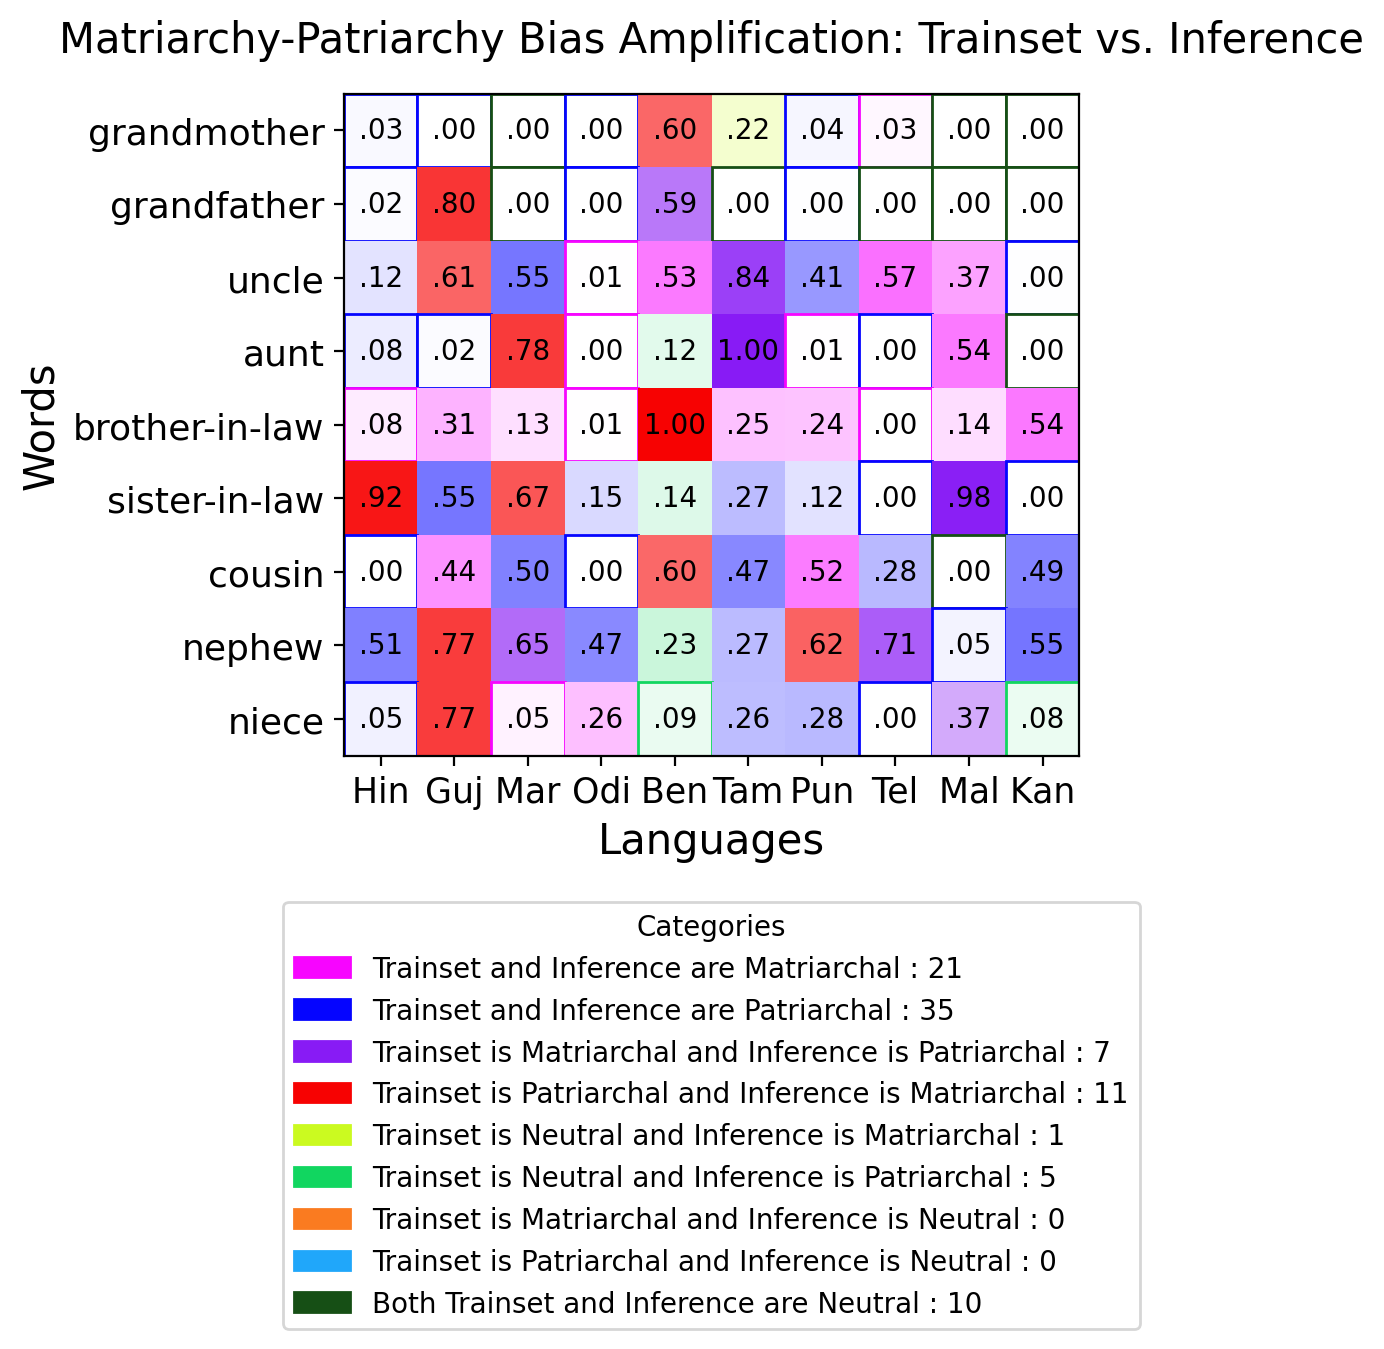

In [57]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

def plot_intensity_mat(data, ambiguos_words, lang_code_map, lang_script_list, filename, legend_title):
    # Define category colors
    category_colors = {
        'A': '#f705ff',  
        'B': '#0505ff',  
        'C': '#881bf5',  
        'D': '#f70202',   

        'E': '#cbfa20',  
        'F': '#11d660',  

        'G': '#fa7b20',  
        'H': '#20a7fa',  
        'I': '#164f15'    

    }
    category_labels ={
        'A': 'Trainset and Inference are Matriarchal',
        'B': 'Trainset and Inference are Patriarchal',
        'C': 'Trainset is Matriarchal and Inference is Patriarchal',
        'D': 'Trainset is Patriarchal and Inference is Matriarchal',
        'E': 'Trainset is Neutral and Inference is Matriarchal',
        'F': 'Trainset is Neutral and Inference is Patriarchal',
        'G': 'Trainset is Matriarchal and Inference is Neutral',
        'H': 'Trainset is Patriarchal and Inference is Neutral',
        'I': 'Both Trainset and Inference are Neutral'
    }
    
    # Convert data to numeric representation for plotting
    categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
    # data_numeric will be the intensity instead of the category
    # data_numeric = np.array([[data[i][j]['intensity'] for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))])
    # print("data numeric::", data_numeric)
    data_numeric = np.array([[data[i][j]['intensity'] for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))])
    print("data numeric::", len(data_numeric), len(data_numeric[0]), data_numeric)
    data_categories = np.array([[data[i][j]['category'] for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))])
    print("data categories::", len(data_categories), len(data_categories[0]), data_categories)
    # Generate individual colormaps for each category
    shaded_cmaps = {c: LinearSegmentedColormap.from_list(c, ["#FFFFFF", category_colors[c]]) for c in categories}
    print(shaded_cmaps)

    # Normalize data_numeric (scales values between 0 and 1)
    # norm = Normalize(vmin=0, vmax=1)
    # Create a custom colormap
    # cmap = ListedColormap([category_colors[c] for c in categories])
    fig, ax = plt.subplots(figsize=(10, 7), dpi = 200)
    # Apply individual shading per category
    for i in range(len(data_numeric)):
        for j in range(len(data_numeric[i])):
            category = data_categories[i][j]  # Get category (e.g., 'A', 'B')
            intensity = data_numeric[i][j]    # Get intensity value (0.0 to 1.0)
            color = shaded_cmaps[category](intensity)  # Get color based on intensity
            ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color, 
                                       edgecolor=category_colors[category] ,
                                         linewidth=1 if intensity <=0.1 else 0))
            # Add Annotation (Display Numeric Value Inside Cell)
            text_color = "black" #if intensity > 0.6 else "white"  # Adjust text color for visibility
            # ax.text(j, i, f'{value:.2f}'.lstrip('0'), ha='center', va='center', fontsize=15, color = 'black')

            ax.text(j+0.5, i+0.5, f'{intensity:.2f}'.lstrip('0'), ha="center", va="center", fontsize=10, color=text_color)


    # Create figure
    # **Fix the top and right borders being cut off**
    ax.set_xlim(0, len(lang_script_list) )  # Extend x-axis
    ax.set_ylim(len(ambiguos_words) , 0)  # Extend y-axis (invert for top alignment)

    
    # Plot confusion matrix with categorical colors
    # cax = ax.matshow(data_numeric, cmap=cmap, )

    # Set x-axis (Languages)
    ax.set_xticks(np.arange(len(lang_script_list)) + 0.5)
    # ax.set_xticklabels([lang_code_map[lang] for lang in lang_script_list], ha="center", fontsize=12)
    ax.set_xticklabels([' '+lang_code_map[lang]+' ' for lang in lang_script_list], ha="center", fontsize=12.5)

    ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to bottom
    ax.xaxis.set_label_position('bottom')  # Move x-axis label to bottom

    # Set y-axis (Words)
    ax.set_yticks(np.arange(len(ambiguos_words)) + 0.5)
    ax.set_yticklabels(ambiguos_words, fontsize=13)
    # ax.set_yticklabels([''] + ambiguos_words, fontsize=15)

    # ax.grid(which="minor", color="black", linestyle='-', linewidth=0.8)  # Grid lines


    # Set labels
    plt.xlabel('Languages', fontsize=15)
    plt.ylabel('Words', fontsize=15)
    plt.title(legend_title, fontsize=15, pad=15)

    # Force cells to be square
    # ax.set_aspect("auto")
    ax.set_aspect("equal")

    # Create a color legend manually
    from matplotlib.patches import Patch
    legend_patches = [Patch(color=category_colors[c], label= category_labels[c]+' : '+str(value_counts.get(c, 0))) for c in categories]
    # ax.legend(handles=legend_patches, title="Categories", loc='lower center', bbox_to_anchor=(0.5, -1.17))
    # Add legend below the plot
    ax.legend(
        handles=legend_patches, 
        title="Categories", 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.2),  # Move it further down
        ncol=1,  # Single column
        frameon=True
    )

    # Adjust layout to prevent shrinking
    plt.subplots_adjust(bottom=0.3)  # Pushes the plot higher so the legend fits



    # Save the plot
    plt.tight_layout()
    # save the plot
    fig.savefig(f'../results/logits_/{filename}.png')
    plt.show()

# Example usage
plot_intensity_mat(norm_test_train_intensity, ambiguos_words, lang_code_map, lang_script_list, 
                     filename='test_train_intensity', 
                     legend_title='Matriarchy-Patriarchy Bias Amplification: Trainset vs. Inference')


## intensity percentage of matriarchy or patriarchy with respect to trainset


In [58]:
test_train_intensity_relative = [[{'category':'X', 'intensity':55} for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))]
# percentage change in intensity with respect to the trainset intensity
for i, word in enumerate(ambiguos_words):
    for j in range(len(lang_script_list)):
        test_train_intensity_relative[i][j]['category'] = test_train_intensity[i][j]['category']
        try:
            temp = abs(test_train_intensity[i][j]['intensity'] - train_diff_confusion_mat[i][j])/train_diff_confusion_mat[i][j]
        except ZeroDivisionError : # 16 out of 90 cells giving zero division error. cannot change GT. thus setting to nan or adding smoothing factor
            print("Zero division error for word, lang ", word, lang_script_list[j]) 
            # test_train_intensity_perc[i][j]['category'] = 'X'
            # test_train_intensity_perc[i][j]['intensity'] = np.nan
            temp = abs(test_train_intensity[i][j]['intensity'] - train_diff_confusion_mat[i][j])/(train_diff_confusion_mat[i][j] + 1e-6)           
        test_train_intensity_relative[i][j]['intensity'] = abs(temp) #*100
print(test_train_intensity_relative)

Zero division error for word, lang  grandmother mar_Deva
Zero division error for word, lang  grandmother tam_Taml
Zero division error for word, lang  grandmother mal_Mlym
Zero division error for word, lang  grandmother kan_Knda
Zero division error for word, lang  grandfather mar_Deva
Zero division error for word, lang  grandfather tam_Taml
Zero division error for word, lang  grandfather tel_Telu
Zero division error for word, lang  grandfather mal_Mlym
Zero division error for word, lang  grandfather kan_Knda
Zero division error for word, lang  aunt ben_Beng
Zero division error for word, lang  aunt kan_Knda
Zero division error for word, lang  sister-in-law ben_Beng
Zero division error for word, lang  cousin mal_Mlym
Zero division error for word, lang  nephew ben_Beng
Zero division error for word, lang  niece ben_Beng
Zero division error for word, lang  niece kan_Knda
[[{'category': 'B', 'intensity': 1.0436328053474426}, {'category': 'B', 'intensity': 1.0040448307991028}, {'category': 'I'

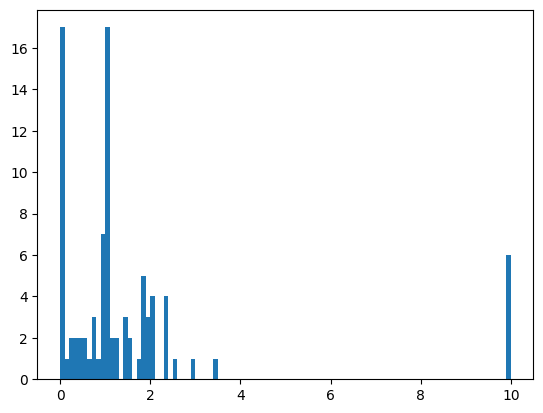

In [59]:
# show the istogram for intensities
intensity_values = []
for i in range(len(ambiguos_words)):
    for j in range(len(lang_script_list)):
        intensity_values.append(test_train_intensity_relative[i][j]['intensity'] if test_train_intensity_relative[i][j]['intensity']<10 else 10)
        test_train_intensity_relative[i][j]['intensity'] = test_train_intensity_relative[i][j]['intensity'] if test_train_intensity_relative[i][j]['intensity']<10 else 10

meadian_intensity = np.median(intensity_values)
plt.hist(intensity_values, bins=100)
plt.savefig('../results/logits_/intensity_hist.png')
# print(meadian_intensity)

# def get_last_non_outlier(arr):
#     arr = np.array(arr)
    
#     # Compute IQR for outlier detection
#     Q1 = np.percentile(arr, 25)
#     Q3 = np.percentile(arr, 75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Filter out outliers
#     filtered_arr = arr[(arr >= lower_bound) & (arr <= upper_bound)]
    
#     # Return the last valid value
#     return filtered_arr[-1] if filtered_arr.size > 0 else None

# print(get_last_non_outlier(intensity_values))



data numeric:: 9 10 [[ 1.04363281  1.00404483  0.          1.00029725  2.03829715 10.
   1.0658561   0.94317865  0.          0.        ]
 [ 1.02721125  2.38336775  0.          1.00096869  0.0205633   0.
   1.00703043  0.          0.          0.        ]
 [ 1.19963789  2.0472399   1.94786331  0.98925227  0.07669368  0.44832546
   1.71024206  0.01398706  0.35211288  1.00693572]
 [ 1.13115573  1.02942002  2.3433623   0.99324748 10.          0.72635567
   0.98803401  1.          0.07173872  0.        ]
 [ 0.86482674  0.46762535  0.77395582  0.9904614   2.90919854  0.57245588
   0.58712244  0.99999988  0.68696449  0.06499302]
 [ 2.58827591  1.94515359  3.49305895  1.26757859 10.          1.50874178
   1.20676712  1.00003338  0.7184908   1.00163865]
 [ 1.002518    0.24629539  1.87266311  1.00041455  2.03204477  1.81847572
   0.09288895  1.47934151  0.          1.85782424]
 [ 1.88292113  2.33414331  0.12576866  1.816796   10.          1.52133023
   2.07009467  0.23404215  1.08158547  1.991025

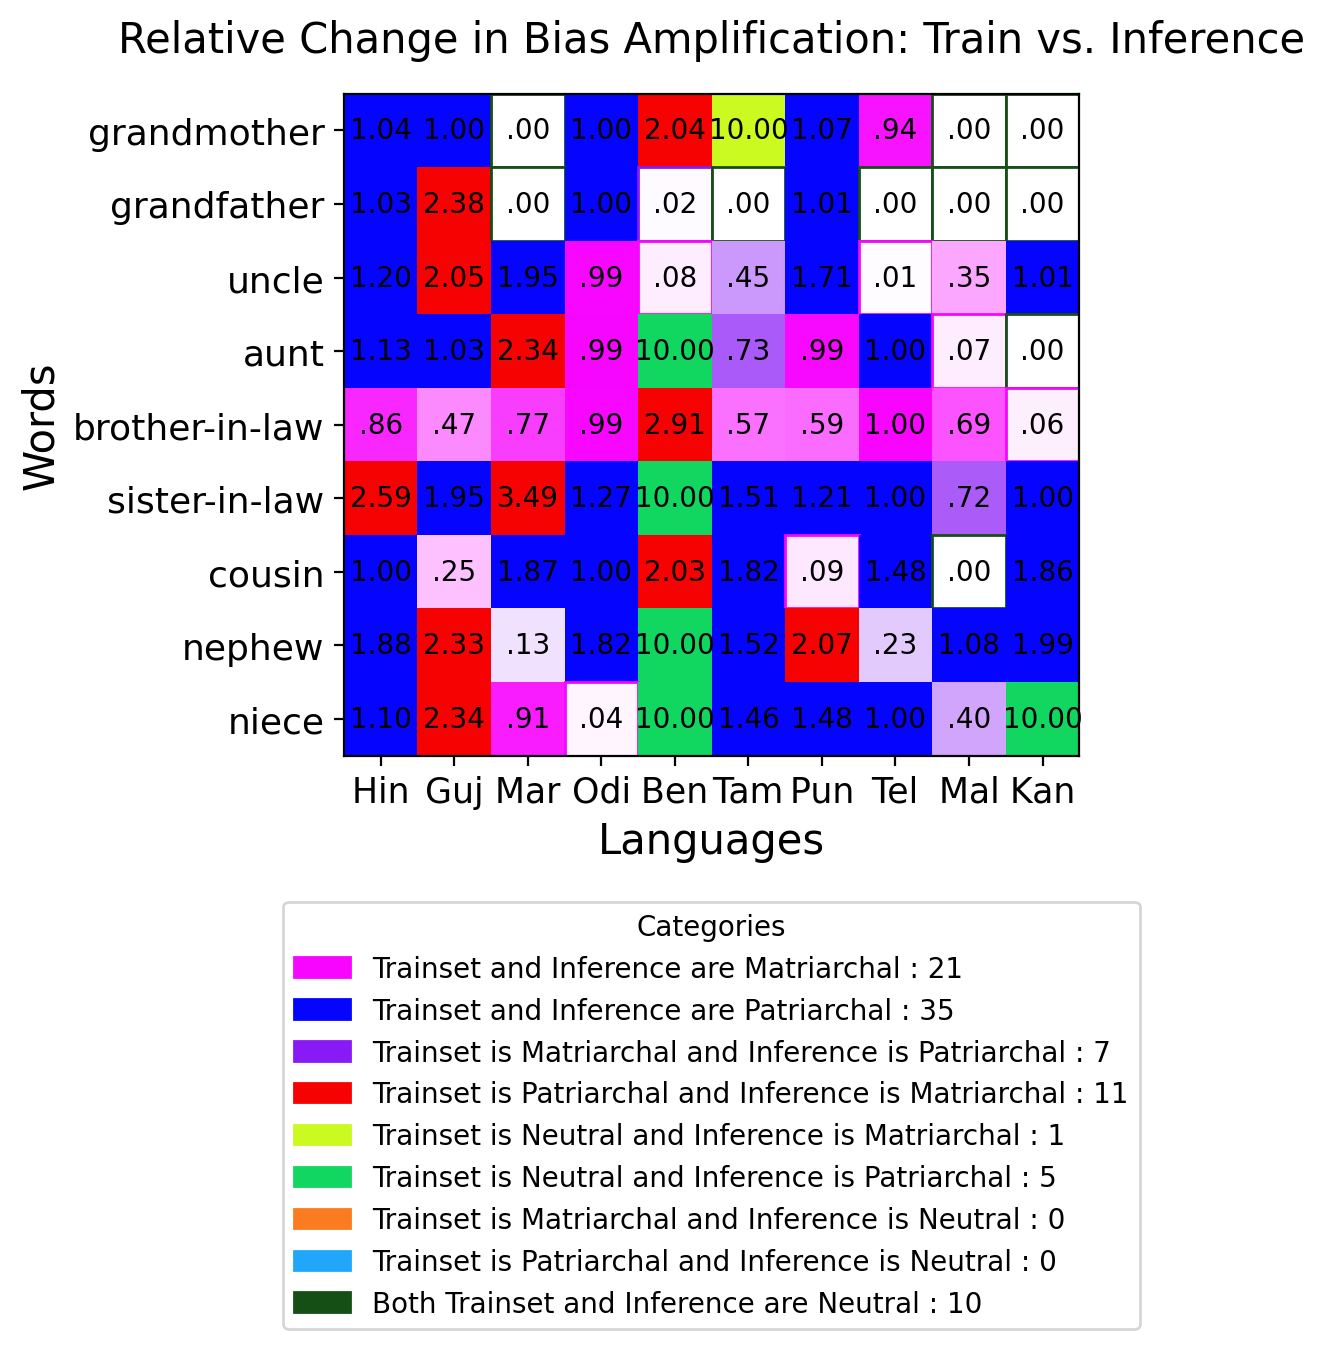

In [60]:
plot_intensity_mat(test_train_intensity_relative, ambiguos_words, lang_code_map, lang_script_list, "test_train_intensity_relative.png", "Relative Change in Bias Amplification: Train vs. Inference")

In [ ]:
#normalize the values of test_train_intensity_perc to 0 to 1 with 0.5 matching to 100% change/intensity
min_intensity_perc = 0
max_intensity_perc = 0
for i in range(len(ambiguos_words)):
    for j in range(len(lang_script_list)):
        intensity_temp = test_train_intensity_relative[i][j]['intensity']
        if intensity_temp < min_intensity_perc:
            min_intensity_perc = intensity_temp
        if intensity_temp > max_intensity_perc:
            max_intensity_perc = intensity_temp

print(min_intensity_perc, max_intensity_perc, test_train_intensity_relative)

norm_test_train_intensity_perc = [[{'category':test_train_intensity_relative[i][j]['category'], 'intensity':55} for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))]
for i in range(len(ambiguos_words)):
    for j in range(len(lang_script_list)):
        intensity_temp = test_train_intensity_relative[i][j]['intensity']
        norm_test_train_intensity_perc[i][j]['intensity'] = (intensity_temp - min_intensity_perc)/(max_intensity_perc - min_intensity_perc)

print(norm_test_train_intensity_perc)

# Extract intensity values
intensity_values = np.array([[cell['intensity'] for cell in row] for row in test_train_intensity_relative])

# Define normalization (0.5 should match 100% intensity change)
min_val = np.min(intensity_values)
max_val = np.max(intensity_values)
normalized_intensity_values = (intensity_values - min_val) / (max_val - min_val)

# Scale so that 100% change corresponds to 0.5 in normalization
normalized_intensity_values = normalized_intensity_values * 0.5 / np.max(normalized_intensity_values[intensity_values <= 100])

print("Nomrliaezd::", normalized_intensity_values)

norm_test_train_intensity_perc = [[{'category':test_train_intensity_relative[i][j]['category'], 'intensity': normalized_intensity_values[i][j]} for j in range(len(lang_script_list))] for i in range(len(ambiguos_words))]
print(norm_test_train_intensity_perc)


0 39046683.90750885 [[{'category': 'B', 'intensity': 104.36328053474426}, {'category': 'B', 'intensity': 100.40448307991028}, {'category': 'I', 'intensity': 0.0}, {'category': 'B', 'intensity': 100.02972483634949}, {'category': 'D', 'intensity': 203.82971508693828}, {'category': 'E', 'intensity': 37290948.62937927}, {'category': 'B', 'intensity': 106.58560991287231}, {'category': 'A', 'intensity': 94.3178653717041}, {'category': 'I', 'intensity': 0.0}, {'category': 'I', 'intensity': 0.0}], [{'category': 'B', 'intensity': 102.72112488746643}, {'category': 'D', 'intensity': 238.33677470684052}, {'category': 'I', 'intensity': 0.0}, {'category': 'B', 'intensity': 100.09686946868896}, {'category': 'C', 'intensity': 2.056330442428589}, {'category': 'I', 'intensity': 0.0}, {'category': 'B', 'intensity': 100.70304274559021}, {'category': 'I', 'intensity': 0.0}, {'category': 'I', 'intensity': 0.0}, {'category': 'I', 'intensity': 0.0}], [{'category': 'B', 'intensity': 119.96378898620605}, {'cate

data numeric:: 9 10 [[5.21816403e-01 5.02022415e-01 0.00000000e+00 5.00148624e-01
  1.01914858e+00 1.86454743e+05 5.32928050e-01 4.71589327e-01
  0.00000000e+00 0.00000000e+00]
 [5.13605624e-01 1.19168387e+00 0.00000000e+00 5.00484347e-01
  1.02816522e-02 0.00000000e+00 5.03515214e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.99818945e-01 1.02361995e+00 9.73931655e-01 4.94626135e-01
  3.83468419e-02 2.24162728e-01 8.55121031e-01 6.99353218e-03
  1.76056438e-01 5.03467858e-01]
 [5.65577865e-01 5.14710009e-01 1.17168115e+00 4.96623741e-01
  1.05980307e+05 3.63177836e-01 4.94017005e-01 5.00000000e-01
  3.58693599e-02 0.00000000e+00]
 [4.32413369e-01 2.33812675e-01 3.86977911e-01 4.95230701e-01
  1.45459927e+00 2.86227942e-01 2.93561220e-01 4.99999940e-01
  3.43482245e-01 3.24965119e-02]
 [1.29413795e+00 9.72576797e-01 1.74652947e+00 6.33789295e-01
  1.22661442e+05 7.54370889e-01 6.03383561e-01 5.00016690e-01
  3.59245400e-01 5.00819325e-01]
 [5.01258999e-01 1.23147696e-01 9.3633

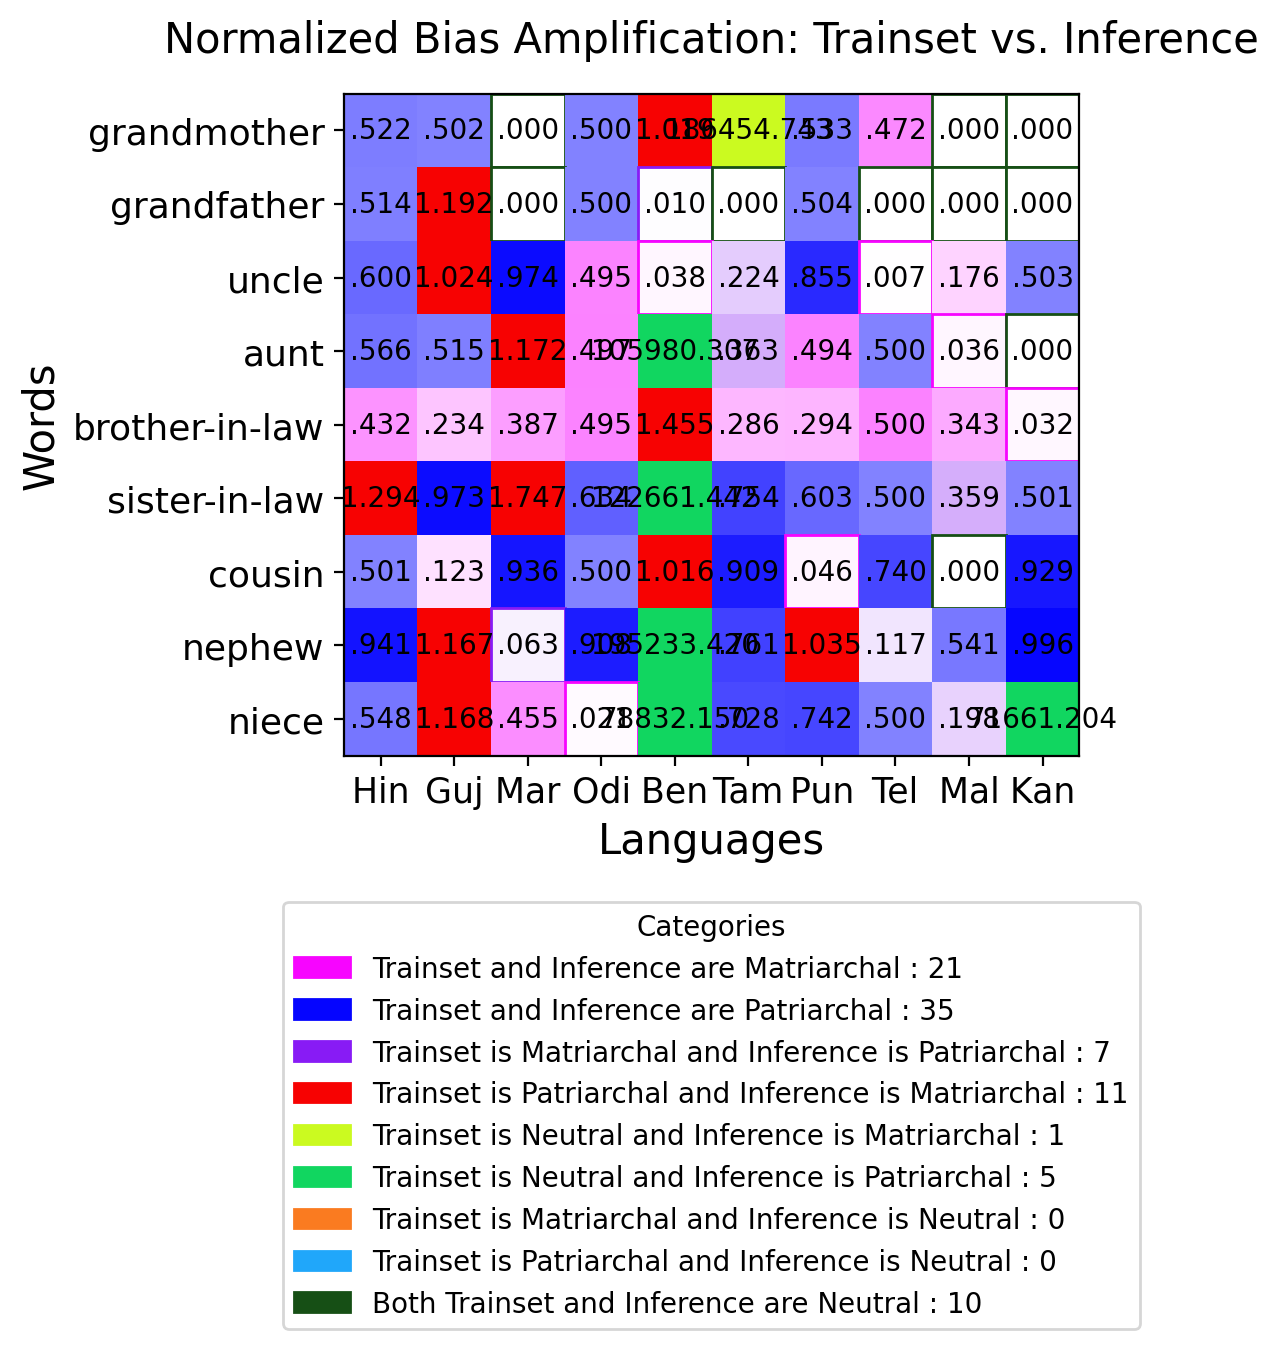

In [23]:
plot_intensity_mat(norm_test_train_intensity_perc, ambiguos_words, lang_code_map, lang_script_list, 'norm_perc_test_train_intensity', 'Normalized Bias Amplification: Trainset vs. Inference')

### Diff??:

In [24]:
# do this test_train_diff_conf_mat = test_diff_confn_mat - train_diff_confusion_mat as they are 2d matrices
test_train_diff_conf_mat = np.subtract(test_diff_confn_mat, train_diff_confusion_mat)
test_train_diff_conf_mat


array([[ 4.36328053e-02,  4.04483080e-03,  0.00000000e+00,
         2.97248363e-04,  1.03829542e+00,  3.72909486e-01,
         6.58560991e-02, -5.68213463e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 2.72112489e-02,  1.38336775e+00,  0.00000000e+00,
         9.68694687e-04, -1.02056330e+00,  0.00000000e+00,
         7.03042746e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.99637890e-01,  1.04723990e+00,  9.47863311e-01,
        -1.07477307e-02, -9.23306316e-01, -1.44832546e+00,
         7.10242063e-01, -9.86012936e-01, -6.47884190e-01,
         6.93571568e-03],
       [ 1.31155729e-01,  2.94200182e-02,  1.34336230e+00,
        -6.66213036e-03, -2.11960614e-01, -1.72635567e+00,
        -1.19659901e-02,  0.00000000e+00, -9.28032219e-01,
         0.00000000e+00],
       [-1.35173261e-01, -5.32374650e-01, -2.26044178e-01,
         9.41091776e-03,  1.72810775e+00, -4.27544117e-01,
        -4.12877560e-01,  1.19209290e-07,  2.38406003e-01,
        -9.

/tmp/ipykernel_1983704/159688876.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ambiguos_words, fontsize=15)


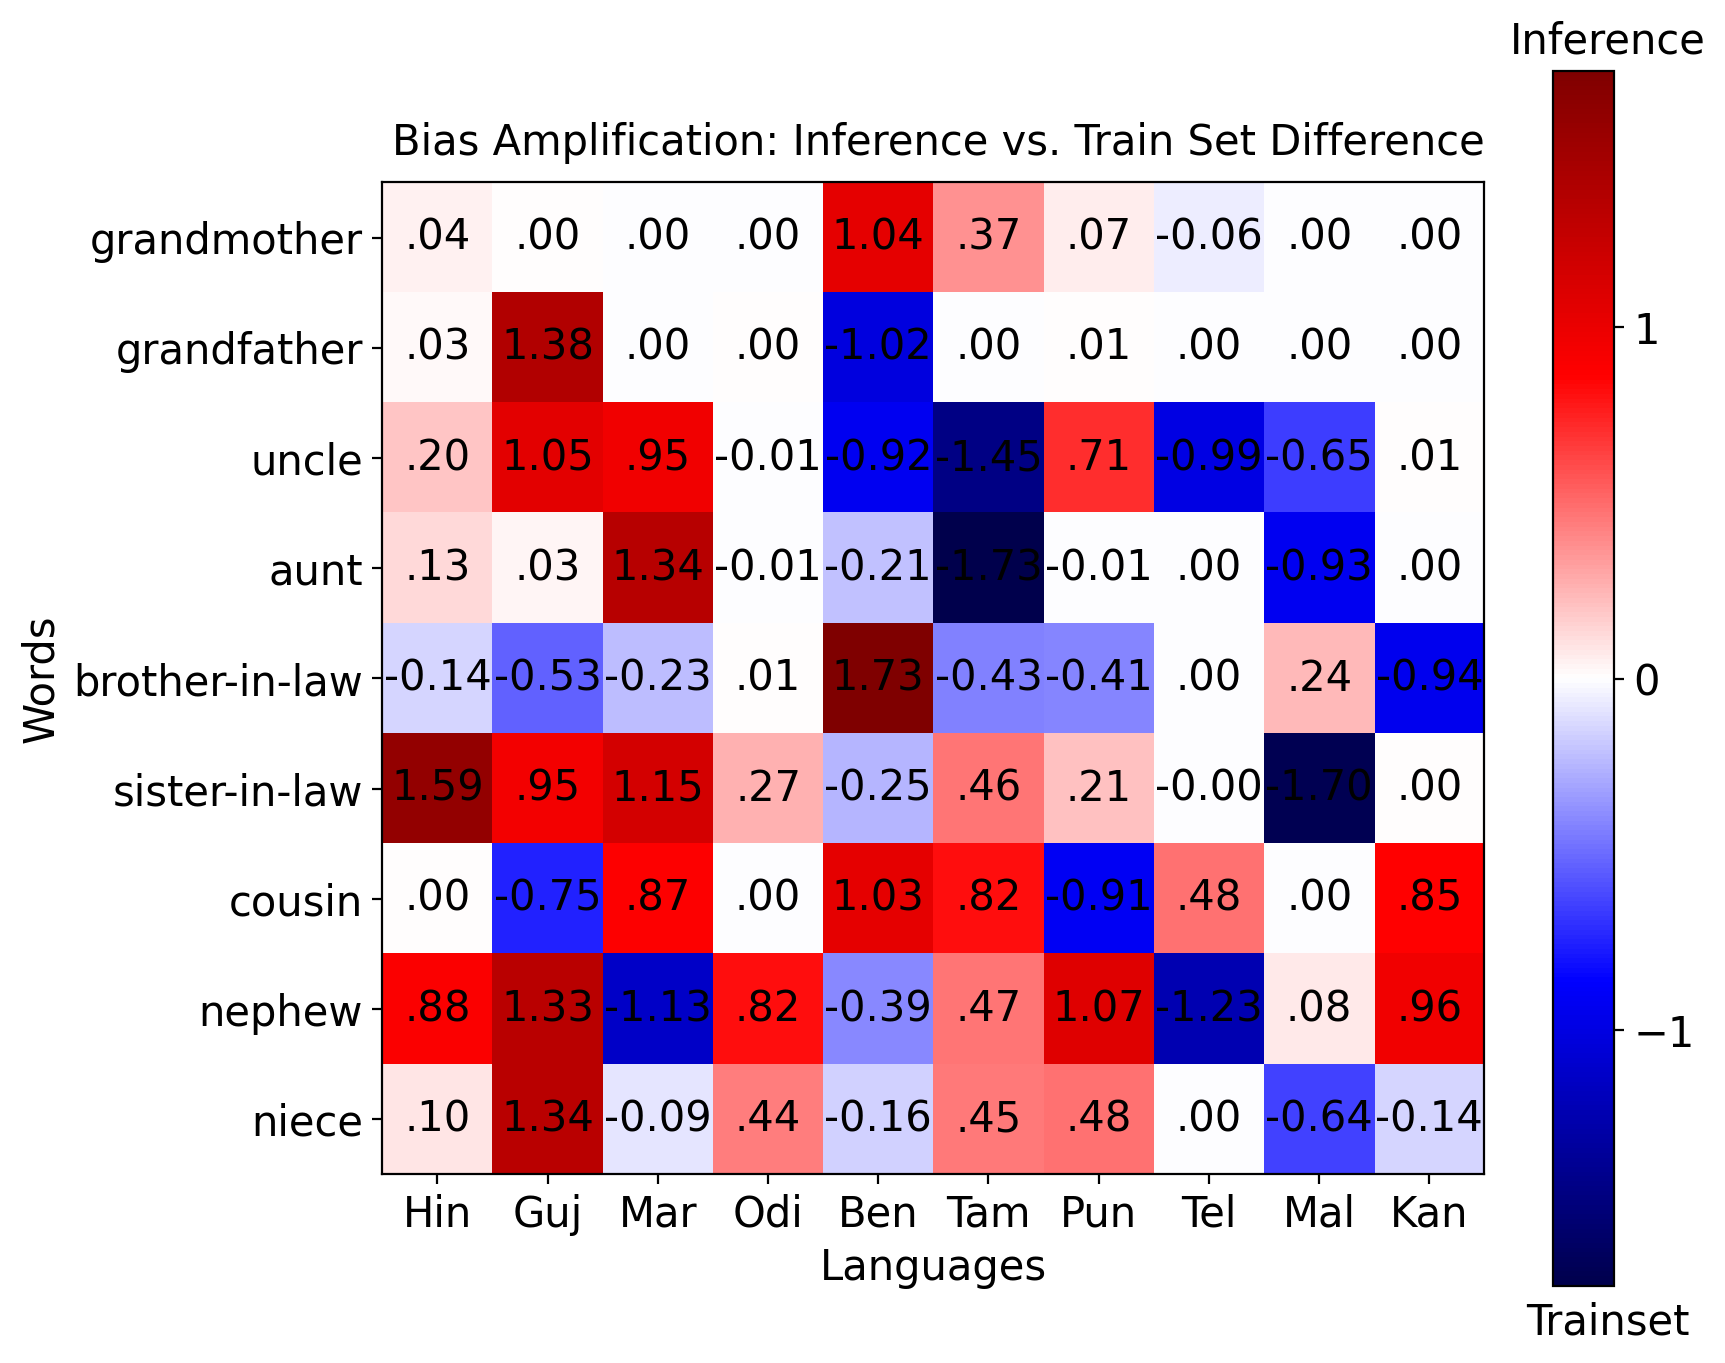

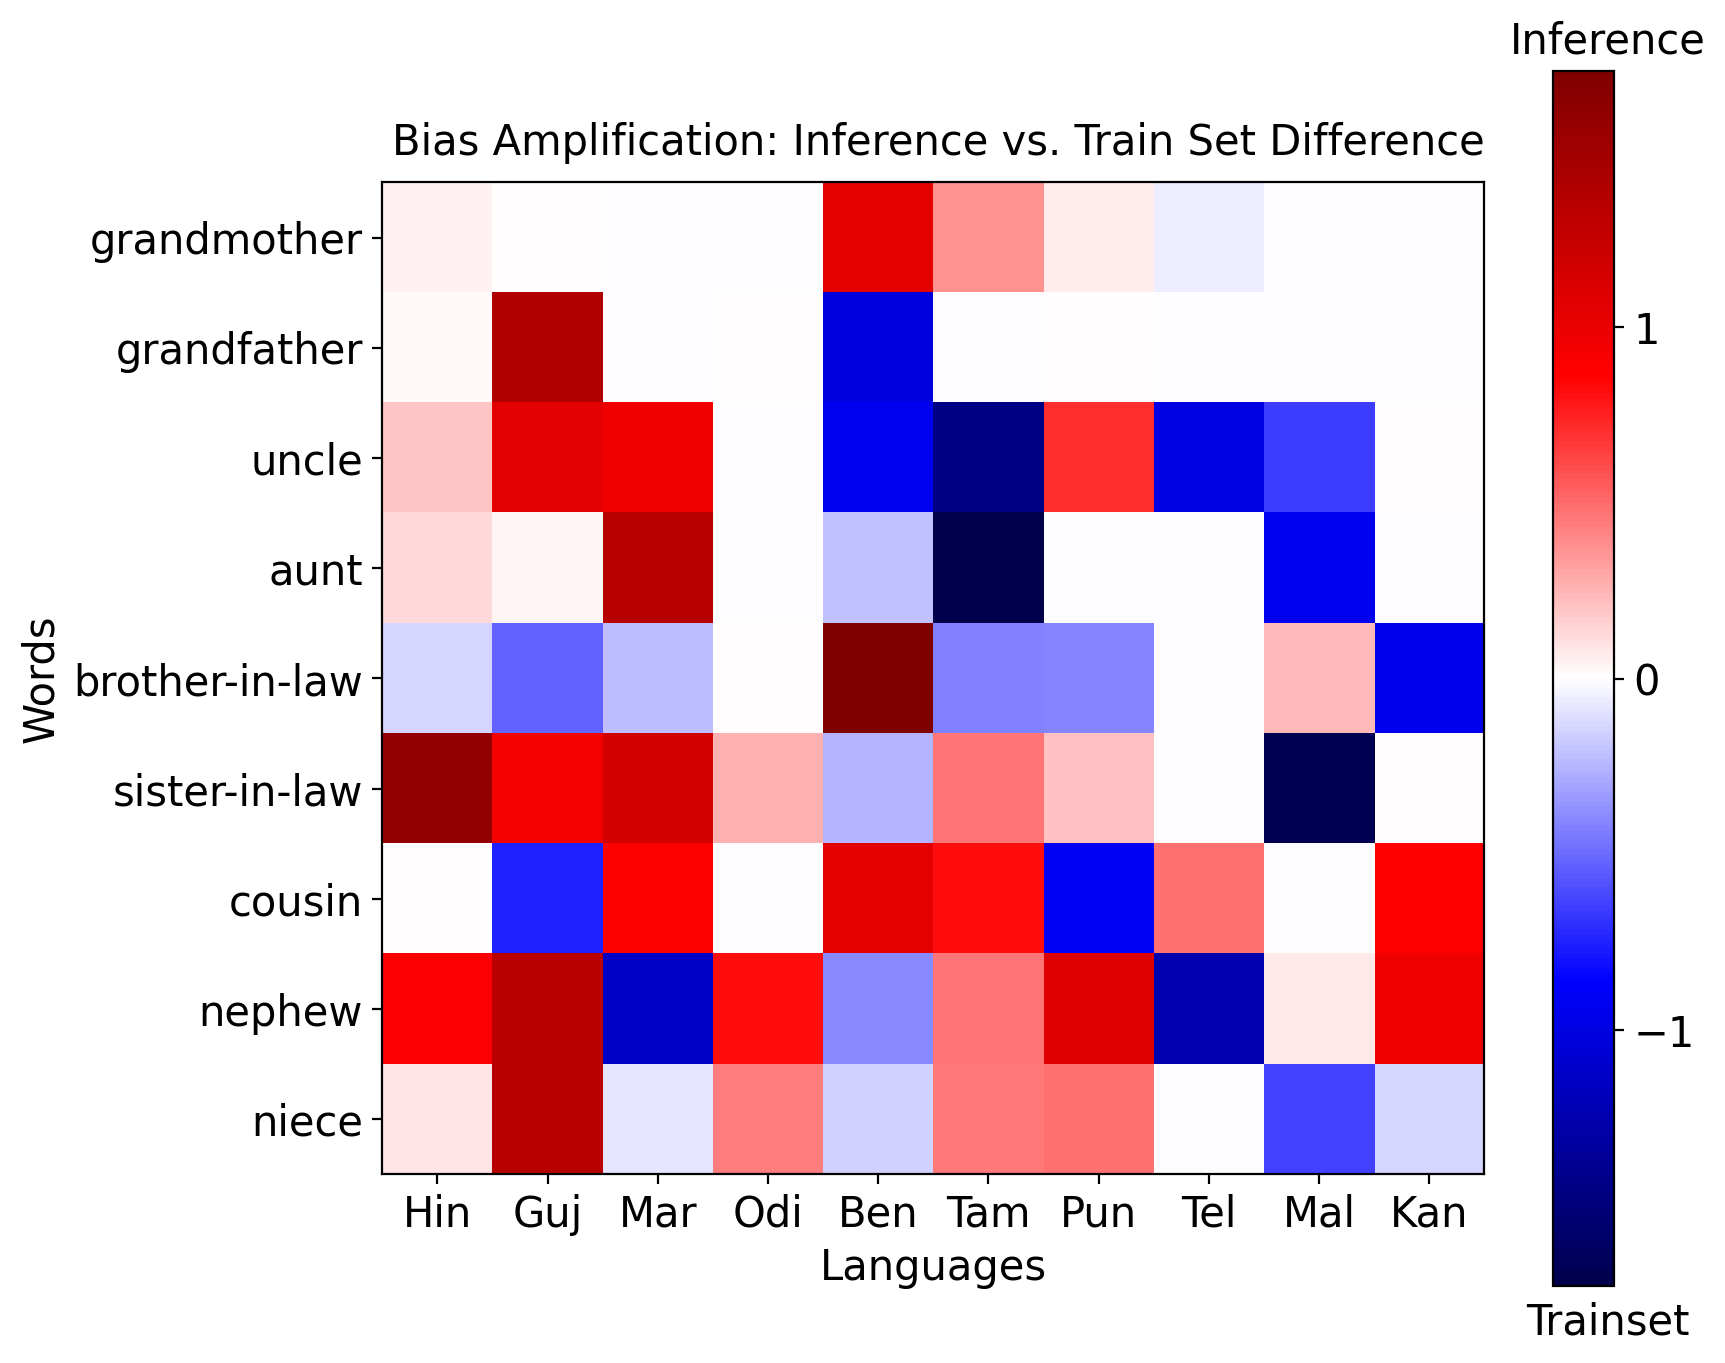

In [25]:
plot_confusion_mat(test_train_diff_conf_mat,  ambiguos_words, lang_code_map, annot=True, filename='test_train_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.seismic, legend_title='Bias Amplification: Inference vs. Train Set Difference', max_label = 'Inference', min_label = 'Trainset')
plot_confusion_mat(test_train_diff_conf_mat,  ambiguos_words, lang_code_map, annot=False, filename='test_train_prob_diff_'+str(SAMPLE_SIZE), cmap_name=plt.cm.seismic, legend_title='Bias Amplification: Inference vs. Train Set Difference', max_label = 'Inference', min_label = 'Trainset')